# Proyecto TRM - Analisis de Residual

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import numpy as np

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [13]:
from pathlib import Path

# Explicitly set the base path to '/content/' where the file is known to reside.
# This ensures the glob operation starts from the correct directory.
base = Path('/content')

# Use a glob pattern that is robust and directly targets the file extension.
# The previous pattern '**/Tasa*colombiano*.*' might have been too broad or
# susceptible to subtle character mismatches, causing it to return an empty list.
candidates = list(base.glob('Tasa*.xlsx'))

# If no candidates are found after the more robust glob, raise the error.
# This catch ensures the program doesn't proceed without the necessary data file.
if not candidates:
    raise FileNotFoundError('No se encontró el archivo de tasa de cambio en el repositorio. Verifique el nombre o la ubicación del archivo.')

# Select the first found file. If multiple files match, this will pick the first one.
file_path = candidates[0]
print(f'Usando archivo: {file_path}')

# Read the dataframe based on its file extension.
# This part of the logic remains unchanged as it correctly handles both .xls/.xlsx and .csv.
if file_path.suffix.lower() in ('.xls', '.xlsx'):
    df = pd.read_excel(file_path)
else:
    df = pd.read_csv(file_path, encoding='latin1', sep=';')

Usando archivo: /content/Tasa de cambio del peso colombiano .xlsx


In [14]:
df_clean = df.iloc[8857-730:8857]
df_clean = df_clean.reset_index(drop=True)
# df_clean = df.iloc[:8857]

In [15]:
# Seleccionamos las columnas y filas de interes para hacer los calculos con pandas
df_preprocessed = df_clean[['periodo', 'trm']]
df_preprocessed

# Se hace el calculo de primera y segunda diferencia
df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)

In [16]:
# Se calcula el valor minimo, maximo, promedio y desviacion estandar de la primera diferencia
min_diff = df_preprocessed['primera_dif'].min()
max_diff = df_preprocessed['primera_dif'].max()
mean_diff = df_preprocessed['primera_dif'].mean()
std_diff = df_preprocessed['primera_dif'].std()
min_trm = df_preprocessed['trm'].min()
max_trm = df_preprocessed['trm'].max()
min_diff, max_diff, mean_diff, std_diff

(-154.6899999999996,
 144.01999999999953,
 np.float64(-1.1582716049382724),
 32.62069875697275)

In [17]:
df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
# Normalización min-max de la columna trm
df_preprocessed['trans_max_min_trm'] = (df_preprocessed['trm'] - min_trm) / (max_trm - min_trm)
df_preprocessed['primera_dif_trans_max_min_trm'] = df_preprocessed['trans_max_min_trm'].diff()


In [18]:
# Se agregan lo rezagos
df_preprocessed['y_t'] = df_preprocessed['estandarizacion']
df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
df_preprocessed['y_t-2'] = df_preprocessed['y_t-1'].shift(1)
df_preprocessed['y_t-3'] = df_preprocessed['y_t-2'].shift(1)


In [19]:
# Promedios moviles (ventana de 2 filas incluyendo la actual)
df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
df_preprocessed['m_3'] = df_preprocessed['y_t'].rolling(window=4, min_periods=4).mean()

In [20]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
0,2023-01-20,4683.85,NaN,NaN,NaN,NaN,0.765168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-23,4631.64,-52.21,NaN,0.343075,-1.565010,0.721764,-0.043403,-1.565010,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-24,4551.02,-80.62,-132.83,0.247966,-2.435930,0.654743,-0.067021,-2.435930,-1.565010,NaN,NaN,-2.000470,NaN,NaN
3,2023-01-25,4545.94,-5.08,-85.70,0.500854,-0.120222,0.650520,-0.004223,-0.120222,-2.435930,-1.565010,NaN,-1.278076,-1.373721,NaN
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-0.180000,-0.120222,-2.435930,-1.565010,-0.150111,-0.912051,-1.075291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-0.420338,0.355856,0.974788,-0.406850,-0.032241,0.303435,0.125864
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-0.280243,-0.420338,0.355856,0.974788,-0.350291,-0.114908,0.157516
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.035507,-0.280243,-0.420338,0.355856,-0.122368,-0.221691,-0.077305
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,0.414101,0.035507,-0.280243,-0.420338,0.224804,0.056455,-0.062743


## Análisis Exploratorio de Datos (EDA)

In [21]:
# Información general del dataset
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"\nCantidad de registros: {len(df_preprocessed)}")
print(f"Cantidad de columnas: {len(df_preprocessed.columns)}")
print(f"\nColumnas: {list(df_preprocessed.columns)}")
print(f"\nRango de fechas: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"\nValores nulos por columna:")
print(df_preprocessed.isnull().sum())

INFORMACIÓN GENERAL DEL DATASET

Cantidad de registros: 730
Cantidad de columnas: 15

Columnas: ['periodo', 'trm', 'primera_dif', 'segunda_dif', 'trans_max_min_primera_dif', 'estandarizacion', 'trans_max_min_trm', 'primera_dif_trans_max_min_trm', 'y_t', 'y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']

Rango de fechas: 2023-01-20 00:00:00 a 2025-11-06 00:00:00

Valores nulos por columna:
periodo                          0
trm                              0
primera_dif                      1
segunda_dif                      2
trans_max_min_primera_dif        1
estandarizacion                  1
trans_max_min_trm                0
primera_dif_trans_max_min_trm    1
y_t                              1
y_t-1                            2
y_t-2                            3
y_t-3                            4
m_1                              2
m_2                              3
m_3                              4
dtype: int64


In [22]:
# Estadísticas descriptivas de las variables principales
print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - TRM")
print("=" * 60)
print(df_preprocessed['trm'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['primera_dif'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['segunda_dif'].describe())


ESTADÍSTICAS DESCRIPTIVAS - TRM
count     730.000000
mean     4158.010452
std       248.679498
min      3763.430000
25%      3958.535000
50%      4111.450000
75%      4281.985000
max      4966.330000
Name: trm, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA
count    729.000000
mean      -1.158272
std       32.620699
min     -154.690000
25%      -20.890000
50%       -0.450000
75%       14.860000
max      144.020000
Name: primera_dif, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA
count    728.000000
mean      -2.202679
std       49.832525
min     -174.160000
25%      -33.560000
50%       -5.355000
75%       23.827500
max      244.520000
Name: segunda_dif, dtype: float64


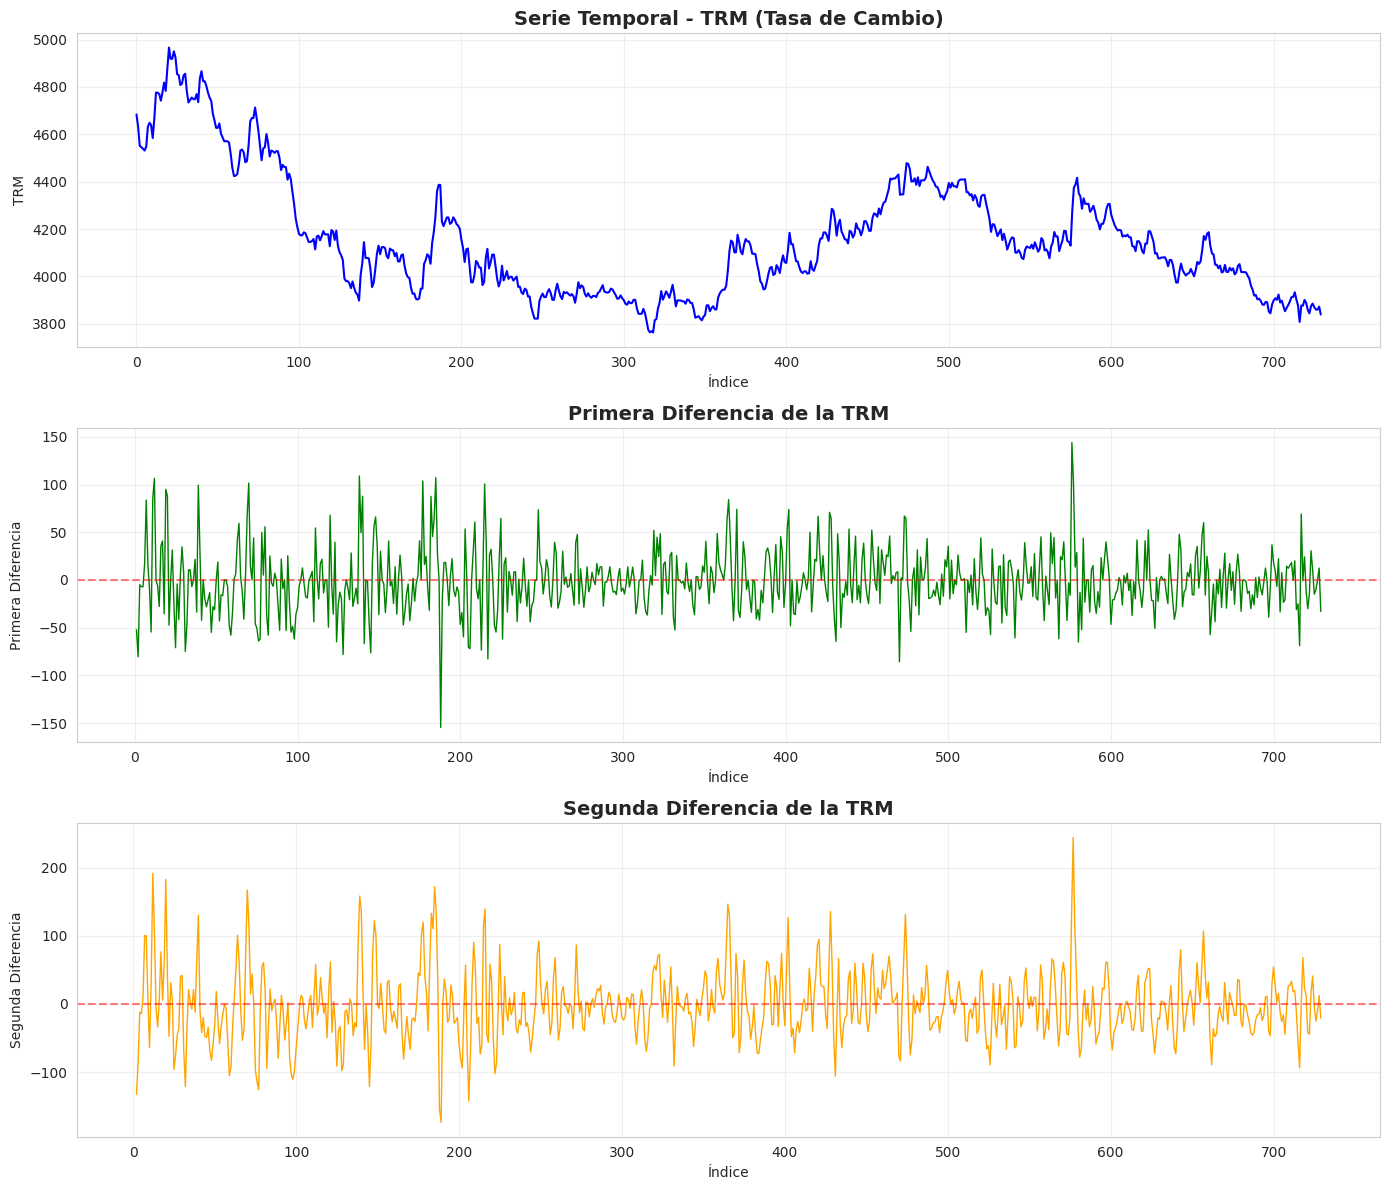

In [23]:
# Serie temporal de la TRM
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# TRM original
axes[0].plot(df_preprocessed.index, df_preprocessed['trm'], color='blue', linewidth=1.5)
axes[0].set_title('Serie Temporal - TRM (Tasa de Cambio)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('TRM')
axes[0].grid(True, alpha=0.3)

# Primera diferencia
axes[1].plot(df_preprocessed.index, df_preprocessed['primera_dif'], color='green', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Primera Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Primera Diferencia')
axes[1].grid(True, alpha=0.3)

# Segunda diferencia
axes[2].plot(df_preprocessed.index, df_preprocessed['segunda_dif'], color='orange', linewidth=1)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Segunda Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Índice')
axes[2].set_ylabel('Segunda Diferencia')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

TRM Original (Gráfico Superior): Muestra una clara tendencia y una media que cambia con el tiempo. Es no estacionaria.Primera Diferencia (Gráfico Medio): La serie fluctúa alrededor de la línea cero, con una media constante y sin tendencia. Esto confirma que $\mathbf{Y_t}$ es estacionaria ($\mathbf{d=0}$ para el modelo $\text{ARMA}$).Segunda Diferencia (Gráfico Inferior): Aunque estacionaria, la varianza es mayor y la serie es innecesaria para el modelado $\text{ARMA}$.

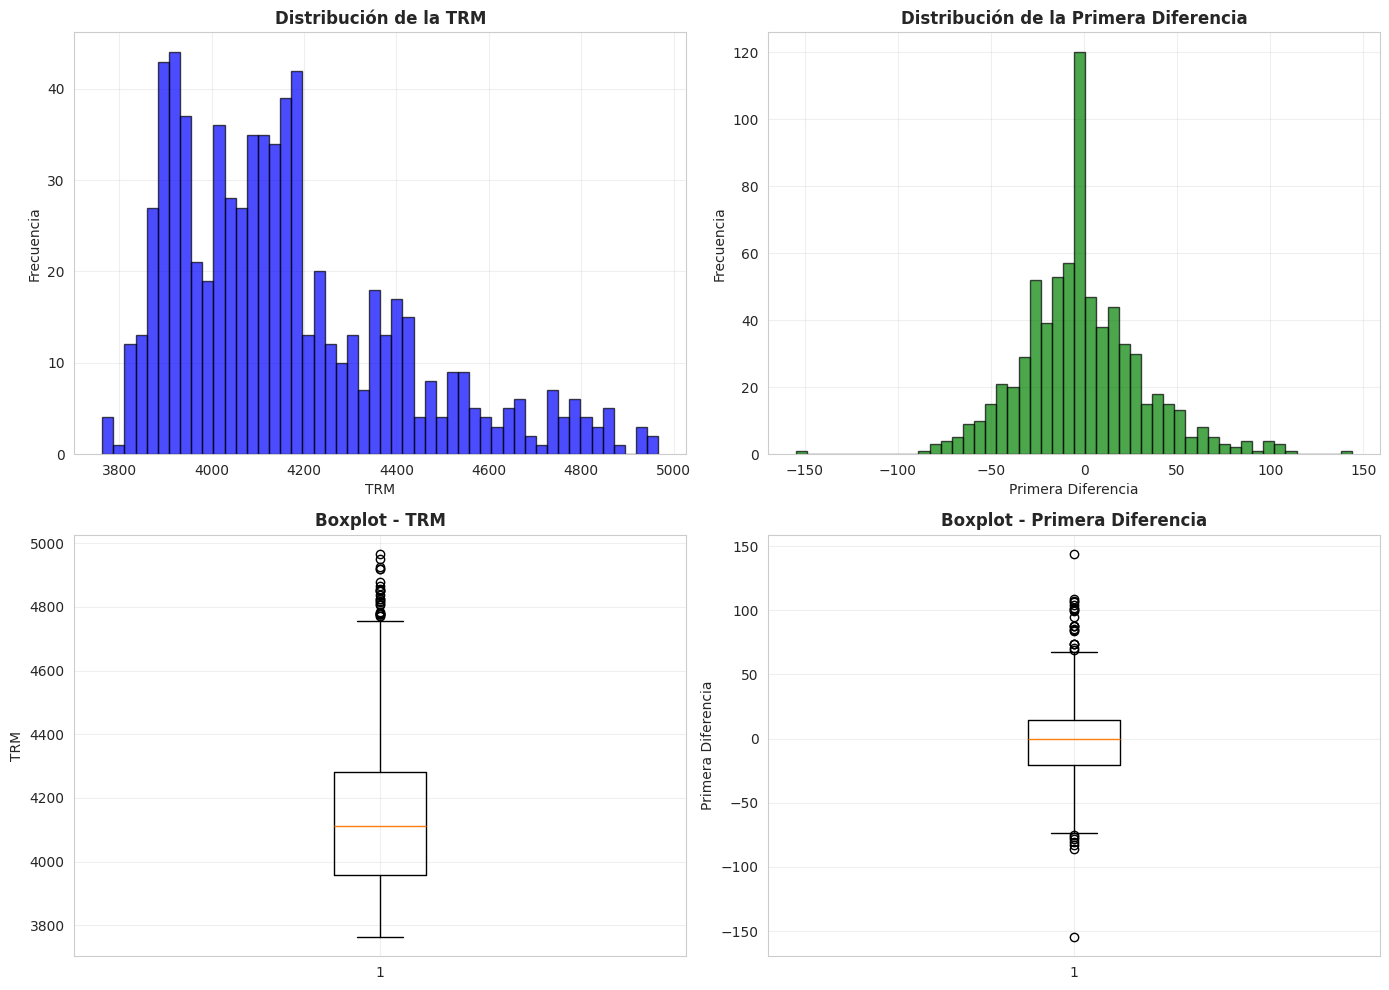

In [24]:
# Histogramas y distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma TRM
axes[0, 0].hist(df_preprocessed['trm'].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de la TRM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('TRM')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma primera diferencia
axes[0, 1].hist(df_preprocessed['primera_dif'].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribución de la Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Primera Diferencia')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot TRM
axes[1, 0].boxplot(df_preprocessed['trm'].dropna(), vert=True)
axes[1, 0].set_title('Boxplot - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('TRM')
axes[1, 0].grid(True, alpha=0.3)

# Boxplot primera diferencia
axes[1, 1].boxplot(df_preprocessed['primera_dif'].dropna(), vert=True)
axes[1, 1].set_title('Boxplot - Primera Diferencia', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Primera Diferencia')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Histograma $\mathbf{Y_t}$ (Primera Diferencia):Es aproximadamente simétrico y centrado en cero, pero con una mayor concentración en el centro y colas más anchas que una distribución normal.

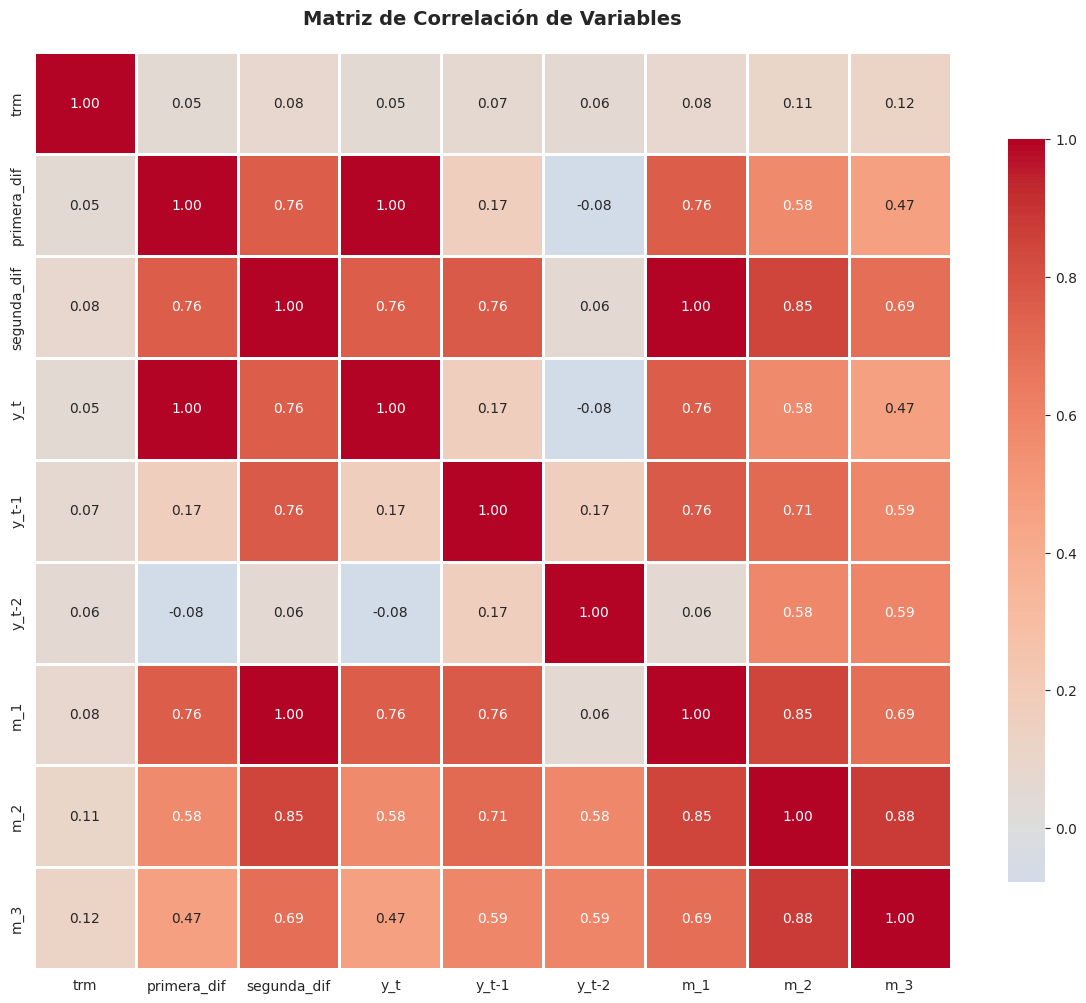

In [25]:
# Matriz de correlación
correlation_cols = ['trm', 'primera_dif', 'segunda_dif', 'y_t', 'y_t-1', 'y_t-2', 'm_1', 'm_2', 'm_3']
corr_matrix = df_preprocessed[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

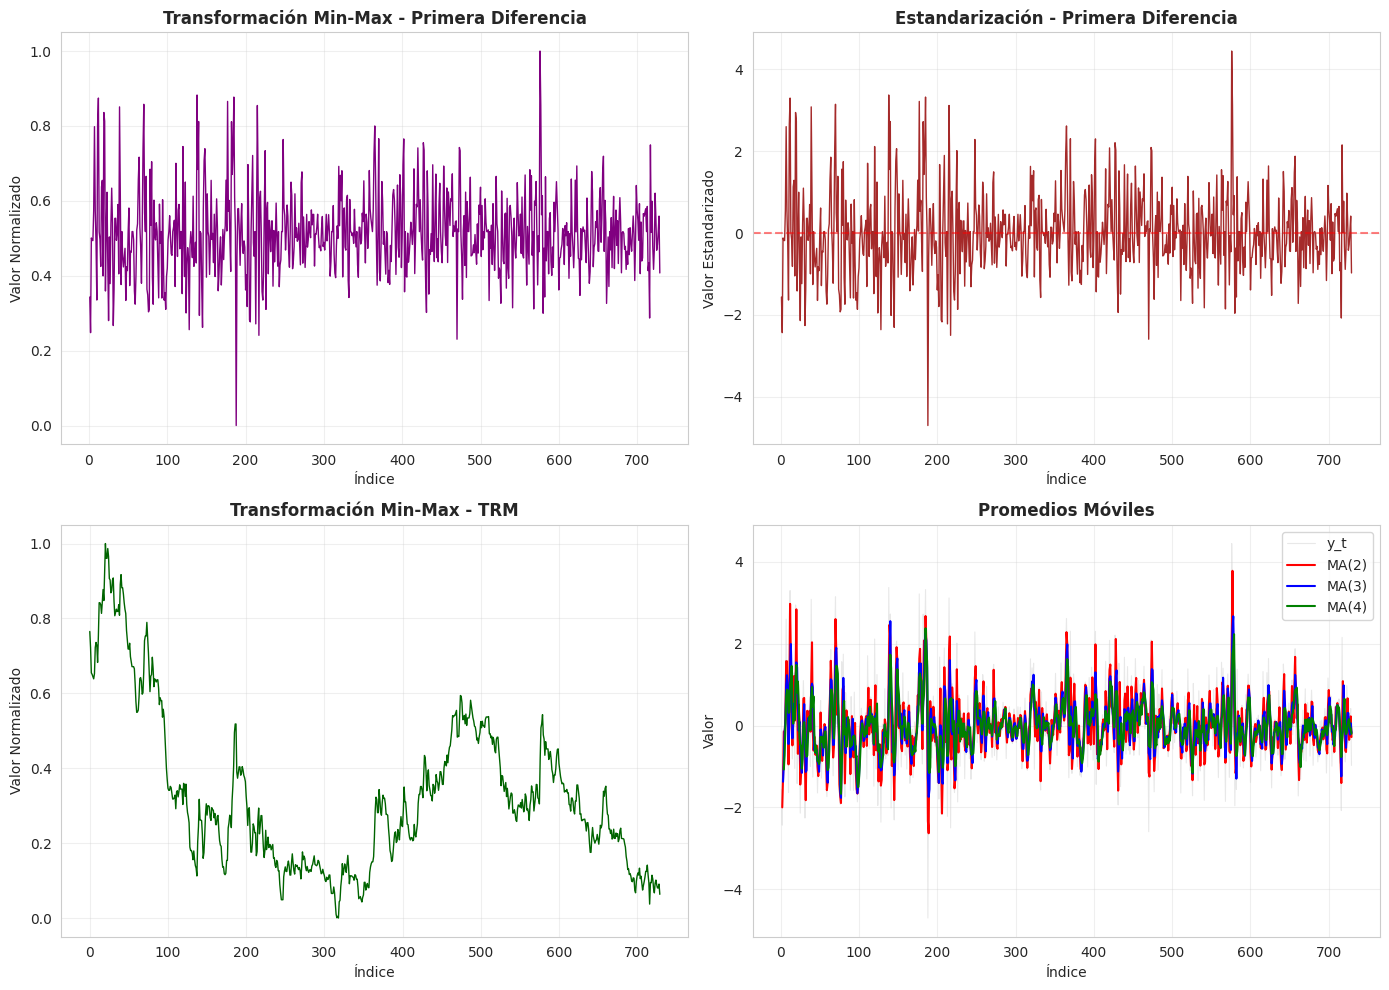

In [26]:
# Análisis de normalización y estandarización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transformación min-max de primera diferencia
axes[0, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_primera_dif'],
                color='purple', linewidth=1)
axes[0, 0].set_title('Transformación Min-Max - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Valor Normalizado')
axes[0, 0].grid(True, alpha=0.3)

# Estandarización
axes[0, 1].plot(df_preprocessed.index, df_preprocessed['estandarizacion'],
                color='brown', linewidth=1)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Estandarización - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('Valor Estandarizado')
axes[0, 1].grid(True, alpha=0.3)

# TRM normalizado
axes[1, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_trm'],
                color='darkgreen', linewidth=1)
axes[1, 0].set_title('Transformación Min-Max - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Valor Normalizado')
axes[1, 0].grid(True, alpha=0.3)

# Promedios móviles
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['y_t'],
                color='lightgray', linewidth=0.8, alpha=0.5, label='y_t')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_1'],
                color='red', linewidth=1.5, label='MA(2)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_2'],
                color='blue', linewidth=1.5, label='MA(3)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_3'],
                color='green', linewidth=1.5, label='MA(4)')
axes[1, 1].set_title('Promedios Móviles', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Índice')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Resumen estadístico final
print("\n" + "=" * 60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("=" * 60)

print("\n1. CARACTERÍSTICAS DEL DATASET:")
print(f"   - Total de observaciones: {len(df_preprocessed)}")
print(f"   - Periodo analizado: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"   - Variables generadas: {len(df_preprocessed.columns)}")

print("\n2. TRM (TASA DE CAMBIO):")
print(f"   - Promedio: {df_preprocessed['trm'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['trm'].median():.2f}")
print(f"   - Mínimo: {df_preprocessed['trm'].min():.2f}")
print(f"   - Máximo: {df_preprocessed['trm'].max():.2f}")
print(f"   - Desviación Estándar: {df_preprocessed['trm'].std():.2f}")

print("\n3. PRIMERA DIFERENCIA:")
print(f"   - Promedio: {df_preprocessed['primera_dif'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['primera_dif'].median():.2f}")
print(f"   - Rango: [{df_preprocessed['primera_dif'].min():.2f}, {df_preprocessed['primera_dif'].max():.2f}]")
print(f"   - Desviación Estándar: {df_preprocessed['primera_dif'].std():.2f}")

print("\n4. VALORES NULOS:")
print(f"   - Total de valores nulos: {df_preprocessed.isnull().sum().sum()}")
print(f"   - Porcentaje de completitud: {((1 - df_preprocessed.isnull().sum().sum() / (len(df_preprocessed) * len(df_preprocessed.columns))) * 100):.2f}%")

print("\n" + "=" * 60)


RESUMEN DEL ANÁLISIS EXPLORATORIO

1. CARACTERÍSTICAS DEL DATASET:
   - Total de observaciones: 730
   - Periodo analizado: 2023-01-20 00:00:00 a 2025-11-06 00:00:00
   - Variables generadas: 15

2. TRM (TASA DE CAMBIO):
   - Promedio: 4158.01
   - Mediana: 4111.45
   - Mínimo: 3763.43
   - Máximo: 4966.33
   - Desviación Estándar: 248.68

3. PRIMERA DIFERENCIA:
   - Promedio: -1.16
   - Mediana: -0.45
   - Rango: [-154.69, 144.02]
   - Desviación Estándar: 32.62

4. VALORES NULOS:
   - Total de valores nulos: 25
   - Porcentaje de completitud: 99.77%



## Análisis de Residual (Ejercicio hecho en clase)

In [28]:
## Limpieza de nulos
df_preprocessed.dropna(inplace=True)
print(df_clean.isnull().sum())

periodo              0
trm                  0
dia                  0
primera_dif          0
segunda_dif          0
trans_max_min        0
estanrazicacion z    0
trans_max_min.1      0
1dif                 0
y_t                  0
y_t-1                0
y_t-2                0
y_t-3                0
m1                   0
m2                   0
m3                   0
m4                   0
m5                   0
dtype: int64


In [29]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-0.180000,-0.120222,-2.435930,-1.565010,-0.150111,-0.912051,-1.075291
5,2023-01-27,4531.75,-7.16,-14.19,0.493890,-0.183985,0.638723,-0.005952,-0.183985,-0.180000,-0.120222,-2.435930,-0.181993,-0.161402,-0.730034
6,2023-01-30,4548.50,16.75,9.59,0.573935,0.548985,0.652648,0.013925,0.548985,-0.183985,-0.180000,-0.120222,0.182500,0.061667,0.016194
7,2023-01-31,4632.20,83.70,100.45,0.798065,2.601363,0.722230,0.069582,2.601363,0.548985,-0.183985,-0.180000,1.575174,0.988787,0.696591
8,2023-02-01,4648.70,16.50,100.20,0.573098,0.541321,0.735946,0.013717,0.541321,2.601363,0.548985,-0.183985,1.571342,1.230556,0.876921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-0.420338,0.355856,0.974788,-0.406850,-0.032241,0.303435,0.125864
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-0.280243,-0.420338,0.355856,0.974788,-0.350291,-0.114908,0.157516
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.035507,-0.280243,-0.420338,0.355856,-0.122368,-0.221691,-0.077305
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,0.414101,0.035507,-0.280243,-0.420338,0.224804,0.056455,-0.062743


In [30]:
# Extraccion de columnas de interes para el entrenamiento
y = df_preprocessed['y_t']
X = df_preprocessed[['y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
display(X.head())
display(y.head())

Shape of X: (726, 6)
Shape of y: (726,)


,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,-0.120222,-2.435930,-1.565010,-0.150111,-0.912051,-1.075291
5,-0.180000,-0.120222,-2.435930,-0.181993,-0.161402,-0.730034
6,-0.183985,-0.180000,-0.120222,0.182500,0.061667,0.016194
7,0.548985,-0.183985,-0.180000,1.575174,0.988787,0.696591
8,2.601363,0.548985,-0.183985,1.571342,1.230556,0.876921


,y_t
4,-0.180000
5,-0.183985
6,0.548985
7,2.601363
8,0.541321


In [31]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X, y, epochs=200, validation_data=(X, y), verbose=1)
print("Model training complete. History stored.")

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9397 - mean_absolute_error: 0.6975 - val_loss: 0.8258 - val_mean_absolute_error: 0.6568
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7299 - mean_absolute_error: 0.6109 - val_loss: 0.5685 - val_mean_absolute_error: 0.5331
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5224 - mean_absolute_error: 0.4984 - val_loss: 0.1996 - val_mean_absolute_error: 0.2933
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1648 - mean_absolute_error: 0.2548 - val_loss: 0.0494 - val_mean_absolute_error: 0.1560
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403 - mean_absolute_error: 0.1425 - val_loss: 0.0249 - val_mean_absolute_error: 0.1028
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - mean_absolute_error: 0.0859 - val_loss: 0.0161 - val_mean_absolute_error: 0.0868
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - mean_absolute_error: 0.0860 - val_los

In [33]:
y_pred = model.predict(X)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [34]:
eval_results = model.evaluate(X, y, verbose=0)
print(f"Model Evaluation - MSE: {eval_results[0]:.2f}, MAE: {eval_results[1]:.2f}")

residuals = y - y_pred.flatten()
print("Residuals calculated.")

Model Evaluation - MSE: 0.00, MAE: 0.01
Residuals calculated.


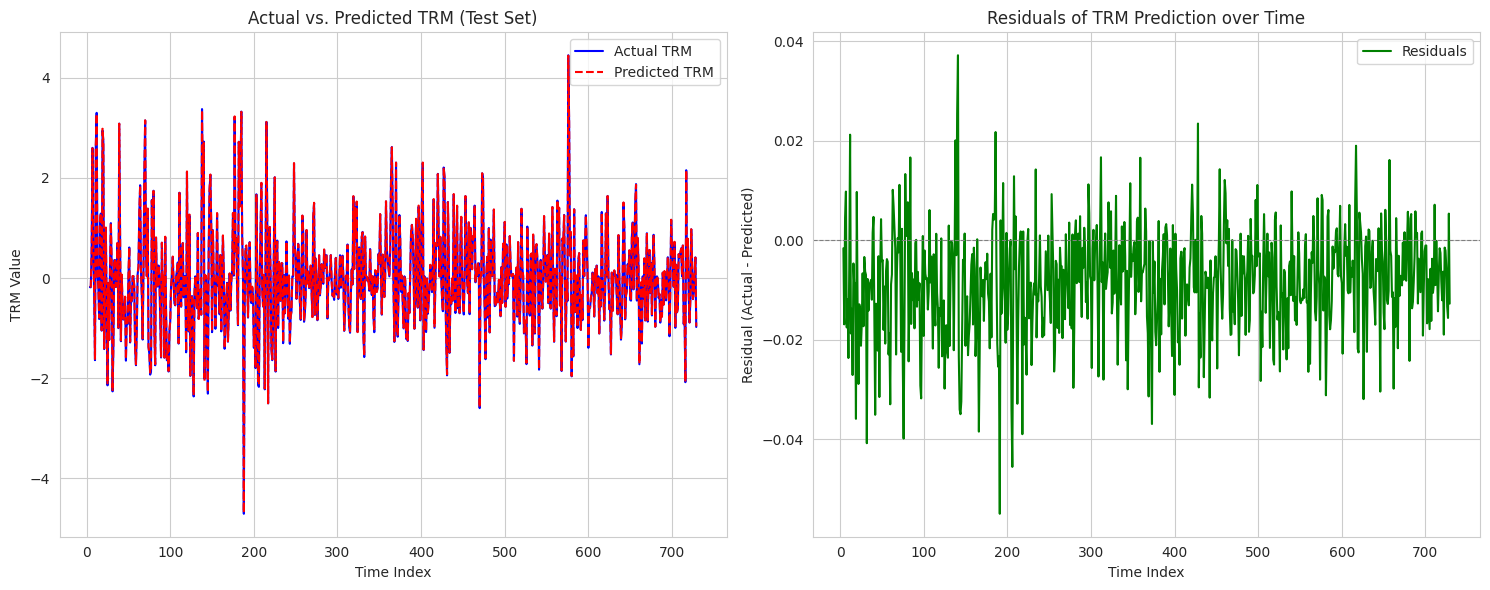

In [35]:
plt.figure(figsize=(15, 6))

# Plot 1: Actual vs. Predicted TRM values
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(y.index, y, label='Actual TRM', color='blue')
plt.plot(y.index, y_pred.flatten(), label='Predicted TRM', color='red', linestyle='--')
plt.title('Actual vs. Predicted TRM (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('TRM Value')
plt.legend()
plt.grid(True)

# Plot 2: Residuals over time
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(y.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Residuals of TRM Prediction over Time')
plt.xlabel('Time Index')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Análisis de Propiedades de los Residuales

A continuación se analizan las propiedades estadísticas de los residuales para validar la calidad del modelo según los criterios vistos en clase:

1. **Valor esperado cero**: El promedio de los residuales debe ser cercano a 0
2. **No autocorrelación**: Los residuales no deben mostrar correlación entre sí a lo largo del tiempo
3. **Aleatoriedad e independencia**: Los residuales deben ser variables aleatorias independientes
4. **Comportamiento como ruido blanco**: Media cercana a 0 y varianza constante (homocedasticidad)

### 1. Propiedades Básicas de los Residuales

In [36]:
# 1. VERIFICACIÓN DE VALOR ESPERADO CERO
print("=" * 70)
print("1. ANÁLISIS DE VALOR ESPERADO (MEDIA) DE LOS RESIDUALES")
print("=" * 70)

mean_residuals = residuals.mean()
std_residuals = residuals.std()
variance_residuals = residuals.var()

print(f"\nMedia de los residuales: {mean_residuals:.6f}")
print(f"Desviación estándar: {std_residuals:.6f}")
print(f"Varianza: {variance_residuals:.6f}")

# Criterio: La media debe ser cercana a 0
if abs(mean_residuals) < 0.01:
    print(f"\n✓ CUMPLE: La media está muy cercana a 0 (|{mean_residuals:.6f}| < 0.01)")
elif abs(mean_residuals) < 0.1:
    print(f"\n⚠ ACEPTABLE: La media está relativamente cerca de 0 (|{mean_residuals:.6f}| < 0.1)")
else:
    print(f"\n✗ NO CUMPLE: La media se aleja de 0 (|{mean_residuals:.6f}| >= 0.1)")

print("\n" + "=" * 70)

1. ANÁLISIS DE VALOR ESPERADO (MEDIA) DE LOS RESIDUALES

Media de los residuales: -0.008535
Desviación estándar: 0.010779
Varianza: 0.000116

✓ CUMPLE: La media está muy cercana a 0 (|-0.008535| < 0.01)



### 2. Test de Autocorrelación de los Residuales

In [37]:
# 2. TEST DE AUTOCORRELACIÓN DE REZAGOS
# Usando statsmodels (equivalente a autocorr() de MATLAB)
from statsmodels.tsa.stattools import acf

print("=" * 70)
print("2. TEST DE AUTOCORRELACIÓN DE REZAGOS")
print("=" * 70)
print("\nCriterio: Correlación entre -0.3 y 0.3 es aceptable")
print("Rezagos analizados: hasta 15 días\n")

# Calcular autocorrelación usando statsmodels (equivalente a MATLAB autocorr)
max_lag = 15
autocorr_values, conf_intervals = acf(
    residuals,
    nlags=max_lag,
    alpha=0.05,  # 95% de confianza
    fft=True
)

# Mostrar resultados (empezando desde lag 1, porque lag 0 siempre es 1.0)
print(f"{'Lag':<5} {'Autocorr':<12} {'Conf.Inf':<12} {'Conf.Sup':<12} {'Status'}")
print("-" * 60)

problematic_lags = 0
for lag in range(1, max_lag + 1):
    corr = autocorr_values[lag]
    lower, upper = conf_intervals[lag]

    # Verificar si está fuera del umbral de ±0.3
    if abs(corr) >= 0.3:
        status = "✗ Alta"
        problematic_lags += 1
    else:
        status = "✓ OK"

    print(f"{lag:<5} {corr:>10.4f}   [{lower:>6.4f}, {upper:>6.4f}]   {status}")

# Resumen
print(f"\nResumen: {problematic_lags}/{max_lag} lags con autocorrelación problemática (|corr| >= 0.3)")

if problematic_lags == 0:
    print("✓ CUMPLE: No hay autocorrelación significativa")
elif problematic_lags <= max_lag * 0.2:
    print("⚠ ACEPTABLE: Baja autocorrelación detectada")
else:
    print("✗ NO CUMPLE: Alta autocorrelación detectada - el modelo no captura toda la estructura")

print("=" * 70)

2. TEST DE AUTOCORRELACIÓN DE REZAGOS

Criterio: Correlación entre -0.3 y 0.3 es aceptable
Rezagos analizados: hasta 15 días

Lag   Autocorr     Conf.Inf     Conf.Sup     Status
------------------------------------------------------------
1         0.1685   [0.0958, 0.2413]   ✓ OK
2        -0.0718   [-0.1465, 0.0030]   ✓ OK
3        -0.0871   [-0.1622, -0.0119]   ✓ OK
4        -0.0456   [-0.1213, 0.0301]   ✓ OK
5        -0.0036   [-0.0794, 0.0722]   ✓ OK
6         0.0670   [-0.0088, 0.1428]   ✓ OK
7         0.0345   [-0.0416, 0.1107]   ✓ OK
8         0.0035   [-0.0727, 0.0798]   ✓ OK
9         0.0682   [-0.0080, 0.1444]   ✓ OK
10        0.0253   [-0.0512, 0.1019]   ✓ OK
11        0.0006   [-0.0760, 0.0772]   ✓ OK
12       -0.0344   [-0.1110, 0.0421]   ✓ OK
13        0.0085   [-0.0682, 0.0852]   ✓ OK
14       -0.0342   [-0.1108, 0.0425]   ✓ OK
15        0.0266   [-0.0502, 0.1034]   ✓ OK

Resumen: 0/15 lags con autocorrelación problemática (|corr| >= 0.3)
✓ CUMPLE: No hay autocorrelación

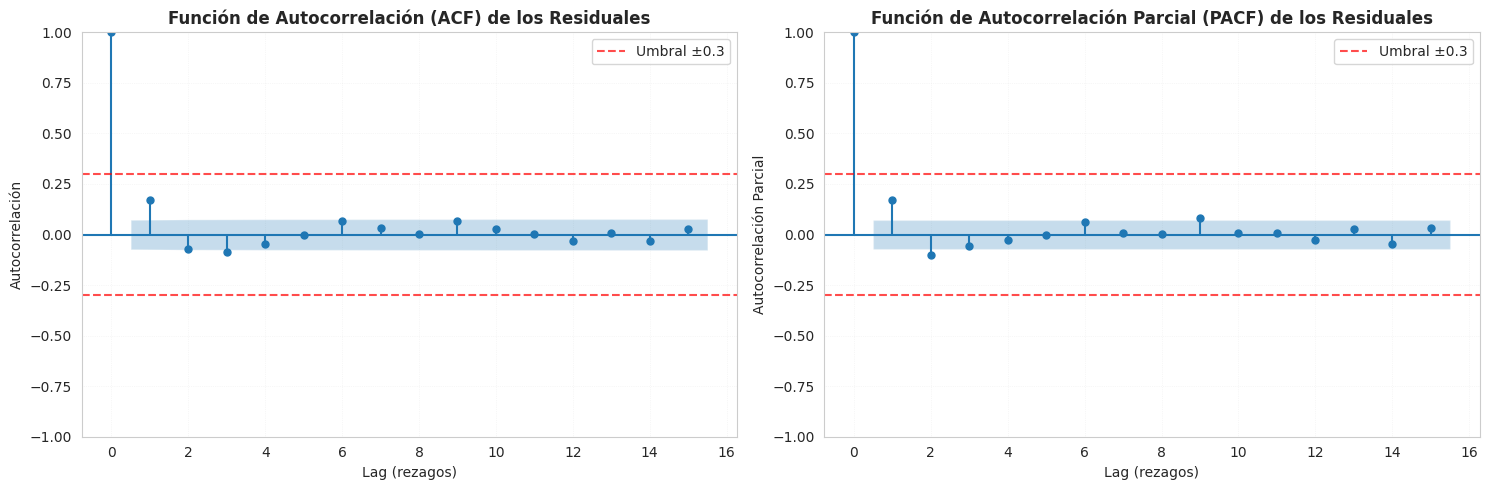


Interpretación:
• ACF: Muestra la correlación entre residuales separados por k lags
• PACF: Muestra la correlación parcial eliminando efectos de lags intermedios
• Bandas azules: Intervalos de confianza al 95%
• Líneas rojas: Umbral crítico de ±0.3
• Idealmente, todos los valores deben estar dentro de las bandas azules


In [38]:
# Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF Plot - Función de Autocorrelación
plot_acf(residuals, lags=max_lag, ax=axes[0], alpha=0.05)
axes[0].set_title('Función de Autocorrelación (ACF) de los Residuales', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (rezagos)', fontsize=10)
axes[0].set_ylabel('Autocorrelación', fontsize=10)
axes[0].axhline(y=0.3, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Umbral ±0.3')
axes[0].axhline(y=-0.3, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# PACF Plot - Función de Autocorrelación Parcial
plot_pacf(residuals, lags=max_lag, ax=axes[1], alpha=0.05)
axes[1].set_title('Función de Autocorrelación Parcial (PACF) de los Residuales', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (rezagos)', fontsize=10)
axes[1].set_ylabel('Autocorrelación Parcial', fontsize=10)
axes[1].axhline(y=0.3, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Umbral ±0.3')
axes[1].axhline(y=-0.3, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("• ACF: Muestra la correlación entre residuales separados por k lags")
print("• PACF: Muestra la correlación parcial eliminando efectos de lags intermedios")
print("• Bandas azules: Intervalos de confianza al 95%")
print("• Líneas rojas: Umbral crítico de ±0.3")
print("• Idealmente, todos los valores deben estar dentro de las bandas azules")

In [39]:
# Correlación entre residuales y variables explicativas (Y_t y X)
print("=" * 70)
print("2.1. CORRELACIÓN ENTRE RESIDUALES Y VARIABLES")
print("=" * 70)

# Correlación entre residuales y Y_t
corr_res_yt = residuals.corr(y)
print(f"\nCorrelación entre residuales y Y_t: {corr_res_yt:.4f}")

# Correlación entre residuales y cada variable explicativa
print("\nCorrelación entre residuales y variables explicativas:")
for col in X.columns:
    corr = residuals.corr(X[col])
    status = "✓" if abs(corr) < 0.3 else "✗"
    print(f"  {col:8s}: {corr:7.4f} {status}")

# Verificar independencia
high_corr_count = sum(1 for col in X.columns if abs(residuals.corr(X[col])) >= 0.3)

if abs(corr_res_yt) < 0.3 and high_corr_count == 0:
    print("\n✓ CUMPLE: Los residuales son independientes de Y_t y X")
else:
    print("\n✗ NO CUMPLE: Existe dependencia entre residuales y las variables")

print("=" * 70)

2.1. CORRELACIÓN ENTRE RESIDUALES Y VARIABLES

Correlación entre residuales y Y_t: 0.4191

Correlación entre residuales y variables explicativas:
  y_t-1   :  0.4071 ✗
  y_t-2   : -0.0862 ✓
  y_t-3   : -0.1817 ✓
  m_1     :  0.5415 ✗
  m_2     :  0.3950 ✗
  m_3     :  0.2624 ✓

✗ NO CUMPLE: Existe dependencia entre residuales y las variables


### 3. Test de Normalidad de los Residuales

In [40]:
# 3. TEST DE NORMALIDAD
# Shapiro-Wilk y Kolmogorov-Smirnov
# P > 0.05 para que el test sea válido (no rechazamos H0: los datos son normales)


print("=" * 70)
print("3. TEST DE NORMALIDAD DE LOS RESIDUALES")
print("=" * 70)
print("\nCriterio: P-value > 0.05 indica normalidad (no se rechaza H0)")

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\n--- Test de Shapiro-Wilk ---")
print(f"Estadístico: {shapiro_stat:.6f}")
print(f"P-value: {shapiro_p:.6f}")

if shapiro_p > 0.05:
    print(f"✓ CUMPLE: Los residuales siguen una distribución normal (p={shapiro_p:.4f} > 0.05)")
else:
    print(f"✗ NO CUMPLE: Los residuales NO siguen una distribución normal (p={shapiro_p:.4f} <= 0.05)")

# Test de Kolmogorov-Smirnov
ks_stat, ks_p = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f"\n--- Test de Kolmogorov-Smirnov ---")
print(f"Estadístico: {ks_stat:.6f}")
print(f"P-value: {ks_p:.6f}")

if ks_p > 0.05:
    print(f"✓ CUMPLE: Los residuales siguen una distribución normal (p={ks_p:.4f} > 0.05)")
else:
    print(f"✗ NO CUMPLE: Los residuales NO siguen una distribución normal (p={ks_p:.4f} <= 0.05)")

print("\nNOTA: Es común que la normalidad sea difícil de lograr completamente.")
print("Lo importante es que se cumplan las propiedades 1, 2 y 4.")
print("=" * 70)

3. TEST DE NORMALIDAD DE LOS RESIDUALES

Criterio: P-value > 0.05 indica normalidad (no se rechaza H0)

--- Test de Shapiro-Wilk ---
Estadístico: 0.990179
P-value: 0.000090
✗ NO CUMPLE: Los residuales NO siguen una distribución normal (p=0.0001 <= 0.05)

--- Test de Kolmogorov-Smirnov ---
Estadístico: 0.040331
P-value: 0.183323
✓ CUMPLE: Los residuales siguen una distribución normal (p=0.1833 > 0.05)

NOTA: Es común que la normalidad sea difícil de lograr completamente.
Lo importante es que se cumplan las propiedades 1, 2 y 4.


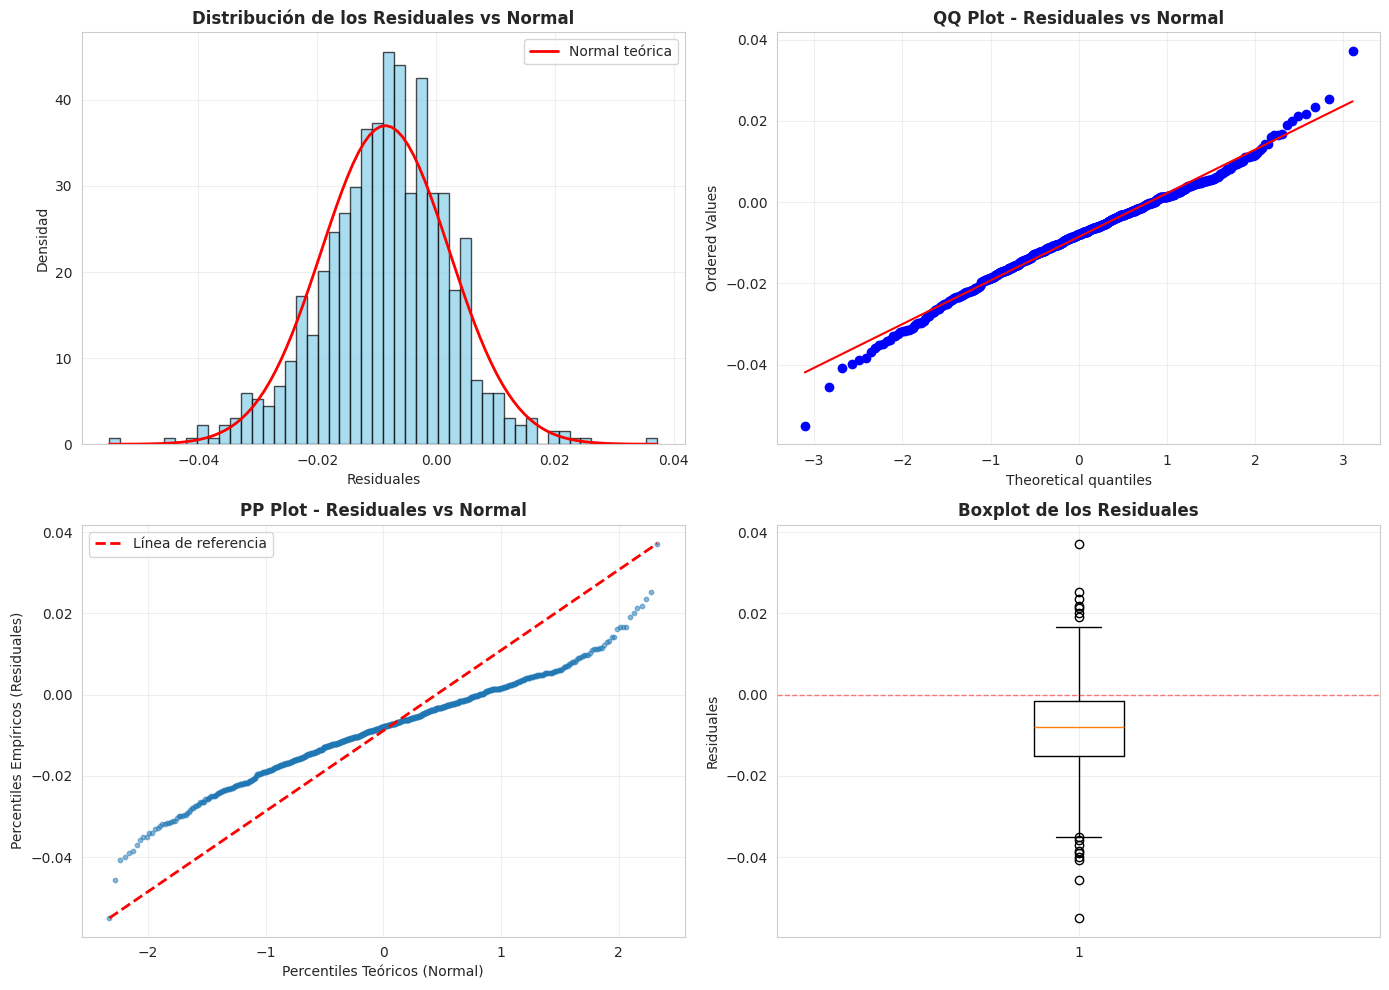

In [41]:
# Gráficos de normalidad: QQ Plot y PP Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de residuales con curva normal
axes[0, 0].hist(residuals, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal teórica')
axes[0, 0].set_title('Distribución de los Residuales vs Normal', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Residuales')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# QQ Plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('QQ Plot - Residuales vs Normal', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# PP Plot (Probability Plot)
# Calculamos los percentiles empíricos y teóricos
sorted_residuals = np.sort(residuals)
norm_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_residuals)))
axes[1, 0].scatter(norm_quantiles, sorted_residuals, alpha=0.5, s=10)
axes[1, 0].plot([norm_quantiles.min(), norm_quantiles.max()],
                 [sorted_residuals.min(), sorted_residuals.max()],
                 'r--', linewidth=2, label='Línea de referencia')
axes[1, 0].set_title('PP Plot - Residuales vs Normal', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Percentiles Teóricos (Normal)')
axes[1, 0].set_ylabel('Percentiles Empíricos (Residuales)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Boxplot de residuales
axes[1, 1].boxplot(residuals, vert=True)
axes[1, 1].set_title('Boxplot de los Residuales', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4. Test ARCH para Homocedasticidad

In [42]:
# 4. TEST ARCH PARA HOMOCEDASTICIDAD
# Es una regresión sobre la varianza - si puedo predecir la varianza hay heterocedasticidad
# H0: No existe heterocedasticidad (responde 0)
# Ha: Existe heterocedasticidad en el Lag de k (responde 1)

from statsmodels.stats.diagnostic import het_arch

print("=" * 70)
print("4. TEST ARCH PARA HOMOCEDASTICIDAD")
print("=" * 70)
print("\nH0: No existe heterocedasticidad (varianza constante)")
print("Ha: Existe heterocedasticidad (varianza NO constante)")
print("Criterio: P-value > 0.05 indica homocedasticidad (no se rechaza H0)\n")

# Test ARCH con diferentes lags
lags_to_test = [1, 3, 5, 10]

for lag in lags_to_test:
    try:
        lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(residuals, nlags=lag)

        print(f"--- Test ARCH (Lag = {lag}) ---")
        print(f"LM Statistic: {lm_stat:.6f}")
        print(f"LM P-value: {lm_pvalue:.6f}")
        print(f"F-statistic: {f_stat:.6f}")
        print(f"F P-value: {f_pvalue:.6f}")

        if lm_pvalue > 0.05:
            print(f"✓ CUMPLE: No hay heterocedasticidad para lag {lag} (p={lm_pvalue:.4f} > 0.05)")
        else:
            print(f"✗ NO CUMPLE: Existe heterocedasticidad para lag {lag} (p={lm_pvalue:.4f} <= 0.05)")
        print()
    except Exception as e:
        print(f"Error en lag {lag}: {e}\n")

print("=" * 70)

4. TEST ARCH PARA HOMOCEDASTICIDAD

H0: No existe heterocedasticidad (varianza constante)
Ha: Existe heterocedasticidad (varianza NO constante)
Criterio: P-value > 0.05 indica homocedasticidad (no se rechaza H0)

--- Test ARCH (Lag = 1) ---
LM Statistic: 11.970255
LM P-value: 0.000541
F-statistic: 12.137635
F P-value: 0.000524
✗ NO CUMPLE: Existe heterocedasticidad para lag 1 (p=0.0005 <= 0.05)

--- Test ARCH (Lag = 3) ---
LM Statistic: 12.558059
LM P-value: 0.005697
F-statistic: 4.236445
F P-value: 0.005568
✗ NO CUMPLE: Existe heterocedasticidad para lag 3 (p=0.0057 <= 0.05)

--- Test ARCH (Lag = 5) ---
LM Statistic: 13.105215
LM P-value: 0.022412
F-statistic: 2.647351
F P-value: 0.022073
✗ NO CUMPLE: Existe heterocedasticidad para lag 5 (p=0.0224 <= 0.05)

--- Test ARCH (Lag = 10) ---
LM Statistic: 21.075592
LM P-value: 0.020573
F-statistic: 2.138116
F P-value: 0.019857
✗ NO CUMPLE: Existe heterocedasticidad para lag 10 (p=0.0206 <= 0.05)



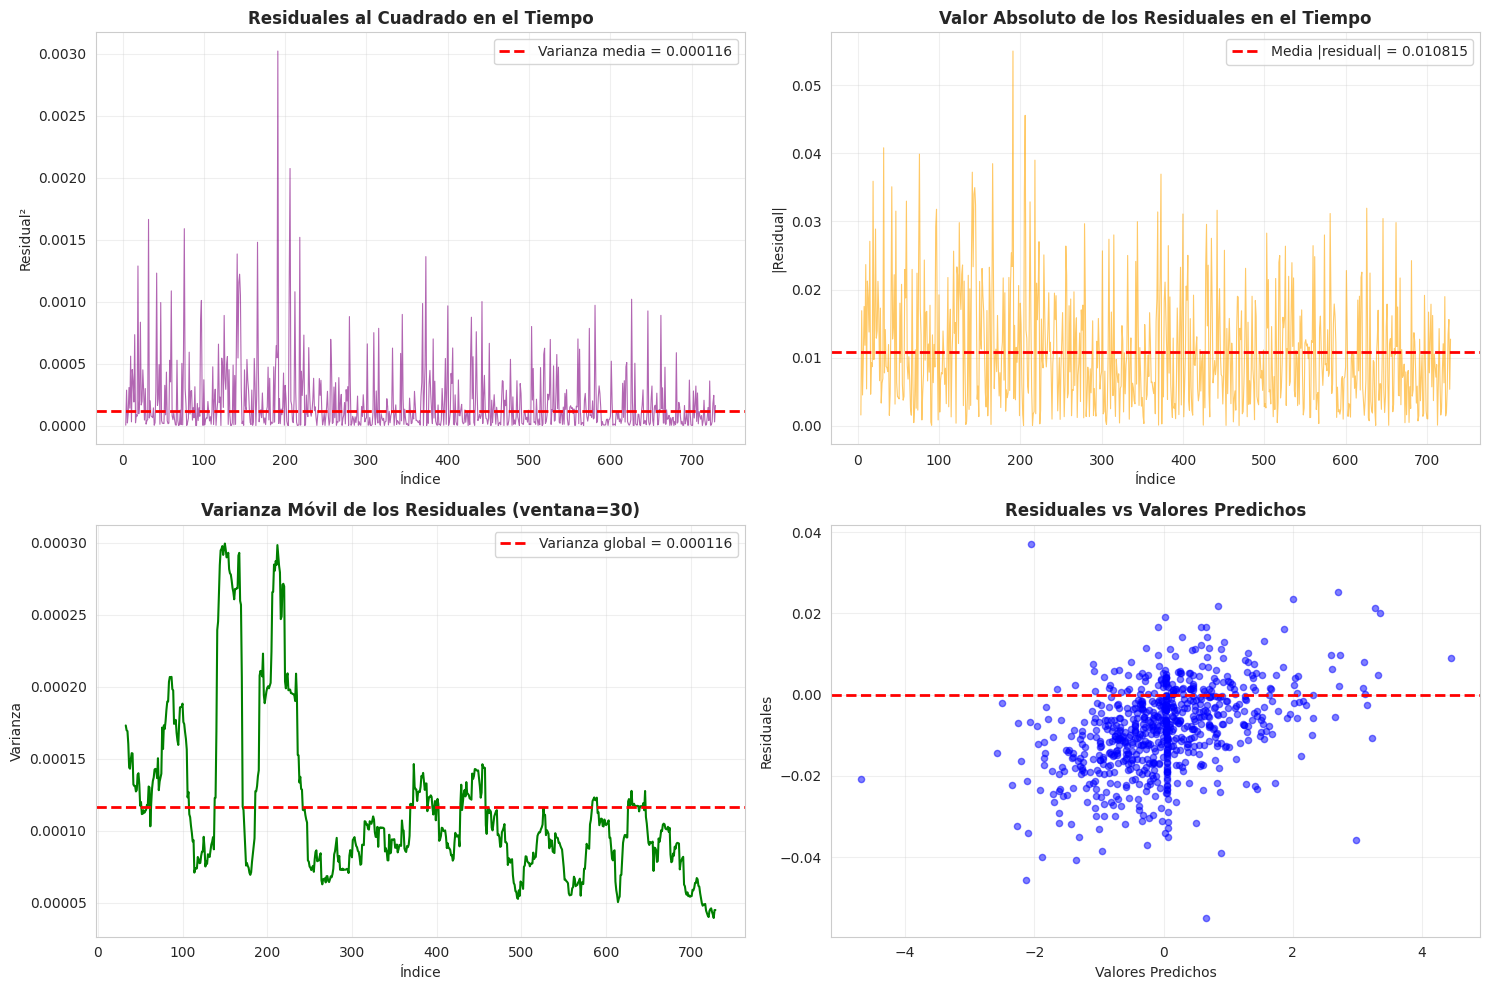


Interpretación visual:
- Si la varianza es constante (homocedasticidad), los residuales² y |residuales| deben distribuirse uniformemente
- La varianza móvil debe mantenerse estable alrededor de la varianza global
- En el scatter, los residuales deben distribuirse aleatoriamente sin formar patrones


In [43]:
# Visualización de varianza en el tiempo (para detectar heterocedasticidad visualmente)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuales al cuadrado en el tiempo
axes[0, 0].plot(residuals.index, residuals**2, color='purple', alpha=0.6, linewidth=0.8)
axes[0, 0].axhline(y=variance_residuals, color='red', linestyle='--', linewidth=2, label=f'Varianza media = {variance_residuals:.6f}')
axes[0, 0].set_title('Residuales al Cuadrado en el Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Residual²')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuales absolutos en el tiempo
axes[0, 1].plot(residuals.index, np.abs(residuals), color='orange', alpha=0.6, linewidth=0.8)
axes[0, 1].axhline(y=np.abs(residuals).mean(), color='red', linestyle='--', linewidth=2, label=f'Media |residual| = {np.abs(residuals).mean():.6f}')
axes[0, 1].set_title('Valor Absoluto de los Residuales en el Tiempo', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('|Residual|')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Rolling variance (ventana de 30)
window_size = min(30, len(residuals) // 3)
rolling_var = residuals.rolling(window=window_size).var()
axes[1, 0].plot(rolling_var.index, rolling_var, color='green', linewidth=1.5)
axes[1, 0].axhline(y=variance_residuals, color='red', linestyle='--', linewidth=2, label=f'Varianza global = {variance_residuals:.6f}')
axes[1, 0].set_title(f'Varianza Móvil de los Residuales (ventana={window_size})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Varianza')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: Residuals vs Fitted values
axes[1, 1].scatter(y_pred.flatten(), residuals, alpha=0.5, s=20, color='blue')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuales vs Valores Predichos', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Valores Predichos')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretación visual:")
print("- Si la varianza es constante (homocedasticidad), los residuales² y |residuales| deben distribuirse uniformemente")
print("- La varianza móvil debe mantenerse estable alrededor de la varianza global")
print("- En el scatter, los residuales deben distribuirse aleatoriamente sin formar patrones")

### 5. Intervalos de Confianza de los Residuales

In [44]:
# 5. INTERVALOS DE CONFIANZA
# Lo ideal es que los residuales queden entre las bandas calculadas con el valor esperado
# de la varianza del residual

print("=" * 70)
print("5. INTERVALOS DE CONFIANZA DE LOS RESIDUALES")
print("=" * 70)

# Calcular intervalos de confianza (95% y 99%)
confidence_levels = [0.95, 0.99]
std_res = residuals.std()
mean_res = residuals.mean()

print(f"\nMedia de los residuales: {mean_res:.6f}")
print(f"Desviación estándar: {std_res:.6f}")
print(f"Varianza: {variance_residuals:.6f}\n")

for conf_level in confidence_levels:
    # Usar distribución normal
    z_score = stats.norm.ppf((1 + conf_level) / 2)
    margin = z_score * std_res
    lower_bound = mean_res - margin
    upper_bound = mean_res + margin

    # Contar cuántos residuales están dentro del intervalo
    within_interval = ((residuals >= lower_bound) & (residuals <= upper_bound)).sum()
    percentage = (within_interval / len(residuals)) * 100

    print(f"--- Intervalo de Confianza del {conf_level*100:.0f}% ---")
    print(f"Límite inferior: {lower_bound:.6f}")
    print(f"Límite superior: {upper_bound:.6f}")
    print(f"Residuales dentro del intervalo: {within_interval}/{len(residuals)} ({percentage:.2f}%)")

    expected_percentage = conf_level * 100
    if percentage >= expected_percentage - 5:  # Tolerancia de 5%
        print(f"✓ CUMPLE: ~{percentage:.1f}% está dentro del intervalo (esperado: {expected_percentage:.0f}%)")
    else:
        print(f"✗ NO CUMPLE: Solo {percentage:.1f}% está dentro del intervalo (esperado: {expected_percentage:.0f}%)")
    print()

print("=" * 70)

5. INTERVALOS DE CONFIANZA DE LOS RESIDUALES

Media de los residuales: -0.008535
Desviación estándar: 0.010779
Varianza: 0.000116

--- Intervalo de Confianza del 95% ---
Límite inferior: -0.029662
Límite superior: 0.012592
Residuales dentro del intervalo: 685/726 (94.35%)
✓ CUMPLE: ~94.4% está dentro del intervalo (esperado: 95%)

--- Intervalo de Confianza del 99% ---
Límite inferior: -0.036301
Límite superior: 0.019231
Residuales dentro del intervalo: 713/726 (98.21%)
✓ CUMPLE: ~98.2% está dentro del intervalo (esperado: 99%)



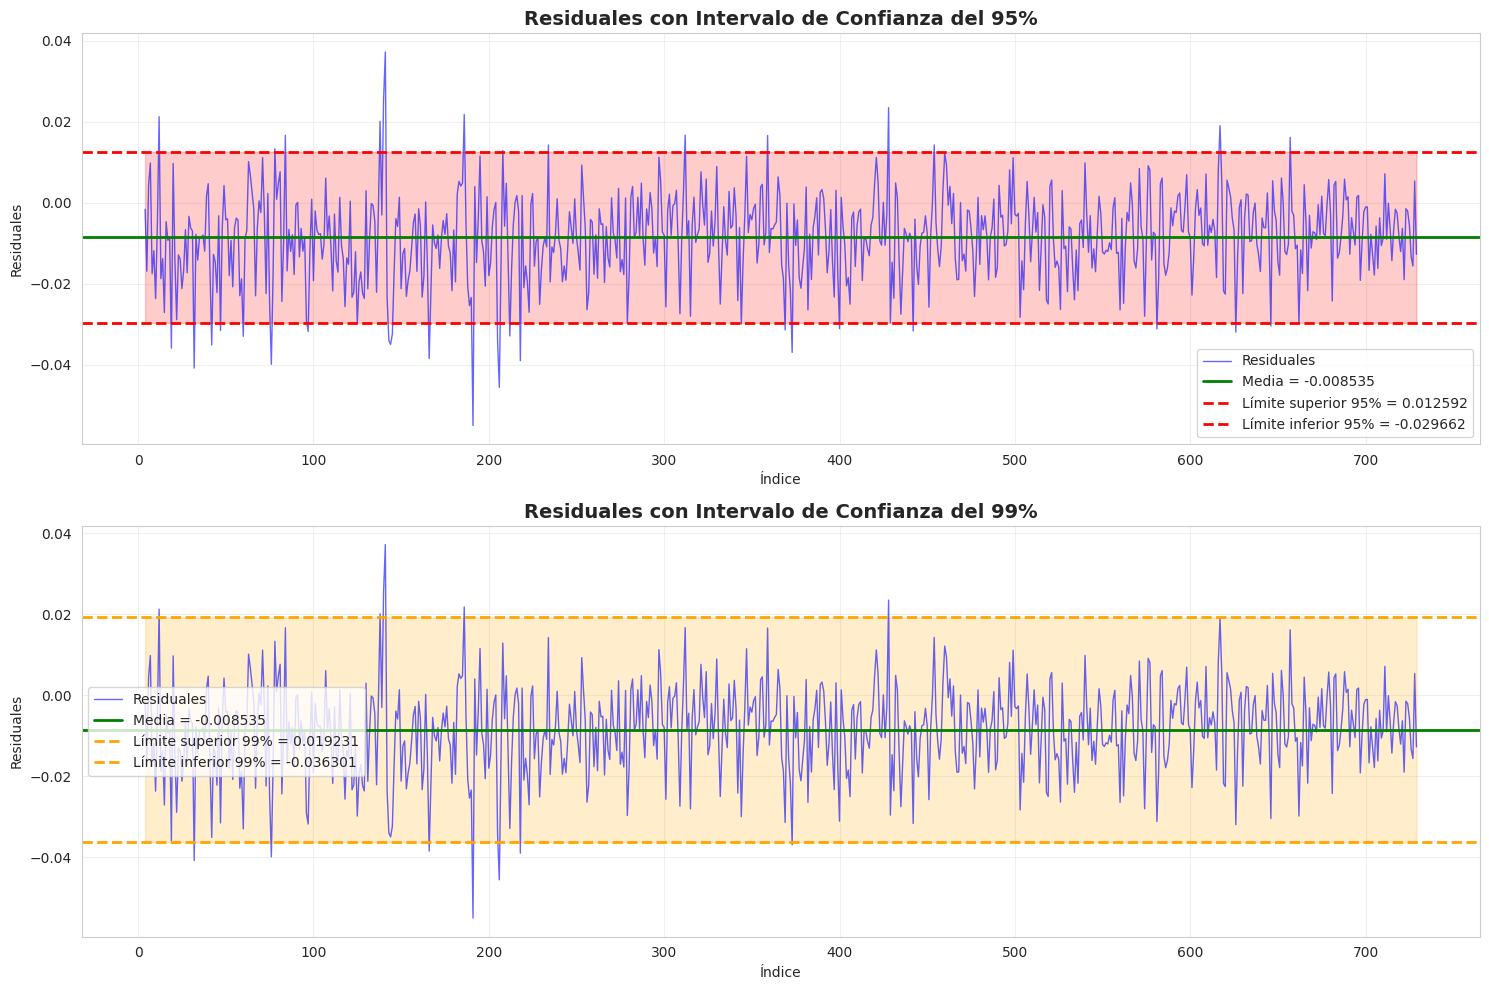


Outliers detectados (fuera del IC 99%): 13/726 (1.79%)
Índices de outliers: [12, 32, 76, 138, 140, 141, 166, 186, 191, 206]...


In [45]:
# Visualización de los residuales con intervalos de confianza
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Residuales con bandas de confianza del 95%
z_95 = stats.norm.ppf(0.975)  # 95% CI
upper_95 = mean_res + z_95 * std_res
lower_95 = mean_res - z_95 * std_res

axes[0].plot(residuals.index, residuals, color='blue', alpha=0.6, linewidth=1, label='Residuales')
axes[0].axhline(y=mean_res, color='green', linestyle='-', linewidth=2, label=f'Media = {mean_res:.6f}')
axes[0].axhline(y=upper_95, color='red', linestyle='--', linewidth=2, label=f'Límite superior 95% = {upper_95:.6f}')
axes[0].axhline(y=lower_95, color='red', linestyle='--', linewidth=2, label=f'Límite inferior 95% = {lower_95:.6f}')
axes[0].fill_between(residuals.index, lower_95, upper_95, alpha=0.2, color='red')
axes[0].set_title('Residuales con Intervalo de Confianza del 95%', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('Residuales')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Residuales con bandas de confianza del 99%
z_99 = stats.norm.ppf(0.995)  # 99% CI
upper_99 = mean_res + z_99 * std_res
lower_99 = mean_res - z_99 * std_res

axes[1].plot(residuals.index, residuals, color='blue', alpha=0.6, linewidth=1, label='Residuales')
axes[1].axhline(y=mean_res, color='green', linestyle='-', linewidth=2, label=f'Media = {mean_res:.6f}')
axes[1].axhline(y=upper_99, color='orange', linestyle='--', linewidth=2, label=f'Límite superior 99% = {upper_99:.6f}')
axes[1].axhline(y=lower_99, color='orange', linestyle='--', linewidth=2, label=f'Límite inferior 99% = {lower_99:.6f}')
axes[1].fill_between(residuals.index, lower_99, upper_99, alpha=0.2, color='orange')
axes[1].set_title('Residuales con Intervalo de Confianza del 99%', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Residuales')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar outliers (fuera del 99% CI)
outliers = residuals[(residuals < lower_99) | (residuals > upper_99)]
print(f"\nOutliers detectados (fuera del IC 99%): {len(outliers)}/{len(residuals)} ({len(outliers)/len(residuals)*100:.2f}%)")
if len(outliers) > 0:
    print(f"Índices de outliers: {list(outliers.index[:10])}{'...' if len(outliers) > 10 else ''}")

### 6. Resumen del Análisis de Residuales

In [46]:
# RESUMEN FINAL DEL ANÁLISIS DE RESIDUALES
print("\n" + "=" * 80)
print(" " * 20 + "RESUMEN DEL ANÁLISIS DE RESIDUALES")
print("=" * 80)

print("\n📊 RESULTADOS DE LAS PRUEBAS ESTADÍSTICAS:\n")

# 1. Valor esperado cero
print("1️⃣  VALOR ESPERADO CERO:")
print(f"   Media de los residuales: {mean_residuals:.6f}")
if abs(mean_residuals) < 0.01:
    print("   ✓ CUMPLE - La media está muy cercana a 0")
elif abs(mean_residuals) < 0.1:
    print("   ⚠ ACEPTABLE - La media está relativamente cerca de 0")
else:
    print("   ✗ NO CUMPLE - La media se aleja significativamente de 0")

# 2. No autocorrelación
print("\n2️⃣  NO AUTOCORRELACIÓN:")
max_lag = min(15, len(residuals) - 1)
autocorr_values = [residuals.iloc[lag:].corr(residuals.iloc[:-lag]) for lag in range(1, max_lag + 1)]
problematic_lags = sum(1 for corr in autocorr_values if abs(corr) >= 0.3)
print(f"   Lags problemáticos (|corr| >= 0.3): {problematic_lags}/{max_lag}")
if problematic_lags == 0:
    print("   ✓ CUMPLE - No hay autocorrelación significativa")
elif problematic_lags <= max_lag * 0.2:
    print("   ⚠ ACEPTABLE - Autocorrelación baja detectada")
else:
    print("   ✗ NO CUMPLE - Alta autocorrelación detectada")

# 3. Independencia
print("\n3️⃣  ALEATORIEDAD E INDEPENDENCIA:")
corr_res_yt = residuals.corr(y)
high_corr_X = sum(1 for col in X.columns if abs(residuals.corr(X[col])) >= 0.3)
print(f"   Correlación residuales-Y_t: {corr_res_yt:.4f}")
print(f"   Variables X con alta correlación: {high_corr_X}/{len(X.columns)}")
if abs(corr_res_yt) < 0.3 and high_corr_X == 0:
    print("   ✓ CUMPLE - Los residuales son independientes")
else:
    print("   ✗ NO CUMPLE - Existe dependencia con variables")

# 4. Normalidad
print("\n4️⃣  NORMALIDAD (Test de Shapiro-Wilk):")
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"   P-value: {shapiro_p:.6f}")
if shapiro_p > 0.05:
    print("   ✓ CUMPLE - Los residuales siguen distribución normal")
else:
    print("   ⚠ NO CUMPLE - Pero es aceptable (la normalidad es difícil de lograr)")

# 5. Homocedasticidad (usando ARCH con lag 1)
print("\n5️⃣  HOMOCEDASTICIDAD (Test ARCH):")
try:
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(residuals, nlags=1)
    print(f"   P-value (Lag 1): {lm_pvalue:.6f}")
    if lm_pvalue > 0.05:
        print("   ✓ CUMPLE - Varianza constante (homocedasticidad)")
    else:
        print("   ✗ NO CUMPLE - Existe heterocedasticidad")
except Exception as e:
    print(f"   ⚠ Error al calcular: {e}")

# 6. Intervalos de confianza
print("\n6️⃣  INTERVALOS DE CONFIANZA (95%):")
z_95 = stats.norm.ppf(0.975)
within_95 = ((residuals >= mean_res - z_95*std_res) & (residuals <= mean_res + z_95*std_res)).sum()
percentage_95 = (within_95 / len(residuals)) * 100
print(f"   Residuales dentro del IC 95%: {percentage_95:.2f}% (esperado: 95%)")
if percentage_95 >= 90:
    print("   ✓ CUMPLE - Los residuales están dentro del intervalo esperado")
else:
    print("   ✗ NO CUMPLE - Muchos residuales fuera del intervalo")

# Conclusión general
print("\n" + "=" * 80)
print("📝 CONCLUSIÓN GENERAL:")
print("=" * 80)

conditions_met = 0
total_conditions = 4  # Condiciones críticas: 1, 2, 3, 4

if abs(mean_residuals) < 0.1:
    conditions_met += 1
if problematic_lags <= max_lag * 0.2:
    conditions_met += 1
if abs(corr_res_yt) < 0.3 and high_corr_X == 0:
    conditions_met += 1
if lm_pvalue > 0.05:
    conditions_met += 1

print(f"\nCondiciones críticas cumplidas: {conditions_met}/{total_conditions}\n")

if conditions_met == total_conditions:
    print("✓✓✓ EXCELENTE: El modelo ha capturado correctamente la estructura de la serie.")
    print("    Los residuales se comportan como ruido blanco.")
elif conditions_met >= total_conditions * 0.75:
    print("✓✓ BUENO: El modelo captura la mayor parte de la estructura de la serie.")
    print("   Hay margen de mejora pero el modelo es aceptable.")
elif conditions_met >= total_conditions * 0.5:
    print("⚠ REGULAR: El modelo captura parcialmente la estructura de la serie.")
    print("  Se recomienda revisar la arquitectura o agregar más variables.")
else:
    print("✗ DEFICIENTE: El modelo NO ha capturado adecuadamente la estructura.")
    print("  Se requieren modificaciones significativas o un modelo más complejo.")

print("\n" + "=" * 80)


                    RESUMEN DEL ANÁLISIS DE RESIDUALES

📊 RESULTADOS DE LAS PRUEBAS ESTADÍSTICAS:

1️⃣  VALOR ESPERADO CERO:
   Media de los residuales: -0.008535
   ✓ CUMPLE - La media está muy cercana a 0

2️⃣  NO AUTOCORRELACIÓN:
   Lags problemáticos (|corr| >= 0.3): 15/15
   ✗ NO CUMPLE - Alta autocorrelación detectada

3️⃣  ALEATORIEDAD E INDEPENDENCIA:
   Correlación residuales-Y_t: 0.4191
   Variables X con alta correlación: 3/6
   ✗ NO CUMPLE - Existe dependencia con variables

4️⃣  NORMALIDAD (Test de Shapiro-Wilk):
   P-value: 0.000090
   ⚠ NO CUMPLE - Pero es aceptable (la normalidad es difícil de lograr)

5️⃣  HOMOCEDASTICIDAD (Test ARCH):
   P-value (Lag 1): 0.000541
   ✗ NO CUMPLE - Existe heterocedasticidad

6️⃣  INTERVALOS DE CONFIANZA (95%):
   Residuales dentro del IC 95%: 94.35% (esperado: 95%)
   ✓ CUMPLE - Los residuales están dentro del intervalo esperado

📝 CONCLUSIÓN GENERAL:

Condiciones críticas cumplidas: 1/4

✗ DEFICIENTE: El modelo NO ha capturado adecuad

In [47]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 22.1 MB/s eta 0:00:00


In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# --- 1. Preparación de Datos ---
file_name = 'Tasa de cambio del peso colombiano .xlsx - Tasa de cambio del peso colombi.csv'
try:
    df = pd.read_csv(file_name, sep=',', encoding='latin-1')
except FileNotFoundError:
    file_name = '/content/Tasa de cambio del peso colombiano (Tasa de cambio del peso colombi).csv'
    df = pd.read_csv(file_name, sep=',', encoding='latin-1')

# Filtrado de últimos 730 datos
y_t_series = df['y_t'].dropna().copy()
Y_t_final = y_t_series.iloc[-730:]

print("=" * 70)
print("ESTRATEGIA DE DOS ETAPAS: ARMA(0,1) + GARCH(1,1)")
print("=" * 70)

# --- ETAPA 1: Modelado de la Media con Statsmodels (ARMA 0,1) ---
# Usamos ARIMA(0, 0, 1) que equivale a ARMA(0, 1)
print("\n--> Etapa 1: Ajustando Media (ARMA 0,1)...")
model_mean = ARIMA(Y_t_final, order=(0, 0, 1))
res_mean = model_mean.fit()
print(res_mean.summary().as_text())

# Extraemos los residuales (e_t) de la etapa 1
residuals_mean = res_mean.resid

# --- ETAPA 2: Modelado de la Varianza con ARCH (GARCH 1,1) ---
# Ajustamos GARCH sobre los residuales. Usamos mean='Zero' porque la media ya se modeló.
print("\n--> Etapa 2: Ajustando Varianza (GARCH 1,1) sobre residuales...")
garch_model = arch_model(residuals_mean, mean='Zero', vol='Garch', p=1, q=1)
res_garch = garch_model.fit(disp='off')
print(res_garch.summary().as_text())

# --- 3. Validación y Diagnóstico Final ---
# Calculamos los residuales estandarizados finales (z_t)
# z_t = e_t / sigma_t
conditional_volatility = res_garch.conditional_volatility
z_t = residuals_mean / conditional_volatility
z_t = z_t.dropna()

print("\n" + "=" * 70)
print("     VALIDACIÓN FINAL DE LAS 3 PROPIEDADES (RESIDUAL ESTANDARIZADO)")
print("=" * 70)

# 1. Media Cero
mean_z = np.mean(z_t)
print(f"1. Media de z_t: {mean_z:.6f} {'✅ CUMPLE' if abs(mean_z) < 0.05 else '❌ NO CUMPLE'}")

# 2. Independencia (Autocorrelación)
lb_p_val = acorr_ljungbox(z_t, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
print(f"2. Independencia (Ljung-Box z_t): P-val={lb_p_val:.4f} {'✅ CUMPLE' if lb_p_val > 0.05 else '❌ NO CUMPLE'}")

# 3. Homocedasticidad (Varianza Constante)
lb_p_val2 = acorr_ljungbox(z_t**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
print(f"3. Homocedasticidad (Ljung-Box z_t^2): P-val={lb_p_val2:.4f} {'✅ CUMPLE' if lb_p_val2 > 0.05 else '❌ NO CUMPLE'}")

# --- 4. Métricas Finales ---
# El MSE final se compara contra los valores reales.
# La predicción de media viene de la Etapa 1.
mse_final = mean_squared_error(Y_t_final, res_mean.fittedvalues)
print(f"\nError Cuadrático Medio (MSE) Final: {mse_final:.4f}")

# Predicción a 1 paso
# Media del ARIMA
forecast_mean = res_mean.forecast(steps=1).iloc[0]
# Varianza del GARCH (forecast del horizonte 1)
forecast_var = res_garch.forecast(horizon=1, reindex=False).variance.iloc[-1, 0]

print(f"\nPredicción (t+1):")
print(f"  Cambio esperado (Media): {forecast_mean:.4f}")
print(f"  Volatilidad esperada (Std): {np.sqrt(forecast_var):.4f}")
print("======================================================================")

ESTRATEGIA DE DOS ETAPAS: ARMA(0,1) + GARCH(1,1)

--> Etapa 1: Ajustando Media (ARMA 0,1)...
                               SARIMAX Results                                
Dep. Variable:                    y_t   No. Observations:                  730
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3566.544
Date:                Wed, 26 Nov 2025   AIC                           7139.087
Time:                        02:03:24   BIC                           7152.867
Sample:                             0   HQIC                          7144.403
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1869      1.447     -0.820      0.412      -4.024       1.650
ma.L1          0.1949      0.031      

ESTADÍSTICAS DE LA VARIABLE TRANSFORMADA (Y_t)
Media original de la diferencia: 0.3553
Desviación estándar original: 19.1447
Nueva Media de Y_t (debe ser ~0): -0.0803
Nueva Std de Y_t (debe ser ~1): 1.7031
------------------------------------------------------------

INICIANDO BÚSQUEDA DEL MEJOR MODELO (GRID SEARCH)...
Modelo          AIC        BIC        Estado
--------------------------------------------------
ARMA(0,1):    2829.13       2842.91       OK
ARMA(0,2):    2829.52       2847.89       OK
ARMA(0,3):    2825.78       2848.74       OK
ARMA(1,0):    2832.93       2846.71       OK
ARMA(1,1):    2830.33       2848.70       OK
ARMA(1,2):    2828.12       2851.09       OK
ARMA(1,3):    2827.53       2855.09       OK
ARMA(2,0):    2826.39       2844.76       OK
ARMA(2,1):    2825.83       2848.79       OK
ARMA(2,2):    2827.12       2854.68       OK
ARMA(2,3):    2828.78       2860.93       OK
ARMA(3,0):    2825.15       2848.11       OK
ARMA(3,1):    2827.14       2854.70       O

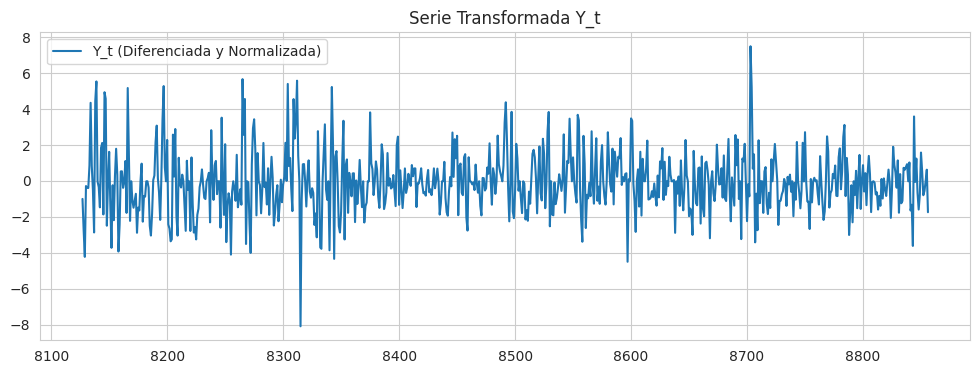

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# ==========================================
# 1. CARGA Y PREPROCESAMIENTO (NUEVAS CONDICIONES)
# ==========================================
# Cargar datos
file_name = 'Tasa de cambio del peso colombiano (Tasa de cambio del peso colombi).csv'
try:
    df = pd.read_csv(file_name, sep=',', encoding='latin-1')
except:
    # Ruta alternativa por si acaso
    df = pd.read_csv('/content/' + file_name, sep=',', encoding='latin-1')

# A. Primera Diferencia (Restar datos sucesivos)
# Creamos una serie temporal pura
trm_series = df['trm'].copy() # Asumiendo que la columna se llama 'trm' o similar
diff_series = trm_series.diff().dropna()

# B. Normalización (Promedio y Desviación Estándar)
# Guardamos media y std para poder "des-normalizar" al final si queremos predecir pesos
mu = diff_series.mean()
sigma = diff_series.std()

# Aplicamos la fórmula: Y_t = (X - mu) / sigma
Y_t_normalizada = (diff_series - mu) / sigma

# Filtramos los últimos 730 datos (Ergodicidad)
Y_t_final = Y_t_normalizada.iloc[-730:]

print("="*60)
print("ESTADÍSTICAS DE LA VARIABLE TRANSFORMADA (Y_t)")
print("="*60)
print(f"Media original de la diferencia: {mu:.4f}")
print(f"Desviación estándar original: {sigma:.4f}")
print(f"Nueva Media de Y_t (debe ser ~0): {Y_t_final.mean():.4f}")
print(f"Nueva Std de Y_t (debe ser ~1): {Y_t_final.std():.4f}")
print("-" * 60)

# ==========================================
# 2. GRID SEARCH (PRUEBA DE MÚLTIPLES MODELOS ARMA)
# ==========================================
print("\nINICIANDO BÚSQUEDA DEL MEJOR MODELO (GRID SEARCH)...")
print(f"{'Modelo':<15} {'AIC':<10} {'BIC':<10} {'Estado'}")
print("-" * 50)

best_aic = float('inf')
best_order = None
best_model = None

# Rangos de búsqueda (p y q entre 0 y 4)
p_values = range(0, 4) # AR: 0, 1, 2, 3
q_values = range(0, 4) # MA: 0, 1, 2, 3
d_value = 0 # Ya diferenciamos manualmente, así que d=0

results_list = []

for p in p_values:
    for q in q_values:
        if p == 0 and q == 0:
            continue # Saltamos el modelo vacío

        try:
            # Ajustamos ARIMA(p, 0, q) a la serie normalizada
            model = ARIMA(Y_t_final, order=(p, d_value, q))
            results = model.fit()

            aic = results.aic
            results_list.append({'order': (p,0,q), 'aic': aic})

            print(f"ARMA({p},{q}):    {aic:.2f}       {results.bic:.2f}       OK")

            # Guardamos el mejor
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d_value, q)
                best_model = results

        except:
            print(f"ARMA({p},{q}):    -----       -----       Falló conv.")

print("="*60)
print(f"🏆 MEJOR MODELO ENCONTRADO: ARMA{best_order} con AIC: {best_aic:.2f}")
print("="*60)

# ==========================================
# 3. VERIFICACIÓN INICIAL DEL MEJOR MODELO
# ==========================================
print("\nResumen del Mejor Modelo:")
print(best_model.summary().as_text())

# Graficamos la serie transformada
plt.figure(figsize=(12, 4))
plt.plot(Y_t_final, label='Y_t (Diferenciada y Normalizada)')
plt.title('Serie Transformada Y_t')
plt.legend()
plt.show()

In [52]:
# ==========================================
# 4. AJUSTE Y DIAGNÓSTICO DEL MODELO GANADOR: ARMA(3, 3)
# ==========================================
print("\n" + "="*70)
print("DIAGNÓSTICO DEL MODELO GANADOR: ARMA(3, 3) (Datos Normalizados)")
print("="*70)

# Ajustamos el modelo ganador sobre la serie Y_t normalizada
# p=3, d=0, q=3
model_winner = ARIMA(Y_t_final, order=(3, 0, 3))
results_winner = model_winner.fit()

print(results_winner.summary().as_text())

# Obtenemos los residuales
residuals_winner = results_winner.resid

# -------------------------------------------------------
# VERIFICACIÓN DE LAS 3 PROPIEDADES
# -------------------------------------------------------
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nResultados de las Pruebas de Diagnóstico:")

# 1. MEDIA CERO
mean_res = residuals_winner.mean()
print(f"1. Media de los residuales: {mean_res:.6f} {'✅ CUMPLE' if abs(mean_res) < 0.05 else '❌ NO CUMPLE'}")

# 2. INDEPENDENCIA (Autocorrelación)
# Ljung-Box sobre los residuales simples
lb_p_val = acorr_ljungbox(residuals_winner, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
print(f"2. Independencia (Ljung-Box e_t): P-value={lb_p_val:.4f} {'✅ CUMPLE' if lb_p_val > 0.05 else '❌ NO CUMPLE'}")

# 3. HOMOCEDASTICIDAD (Varianza Constante) - LA PRUEBA CRÍTICA
# Ljung-Box sobre los residuales al cuadrado
lb_p_val2 = acorr_ljungbox(residuals_winner**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
print(f"3. Homocedasticidad (Ljung-Box e_t^2): P-value={lb_p_val2:.4f} {'✅ CUMPLE' if lb_p_val2 > 0.05 else '❌ NO CUMPLE'}")

# -------------------------------------------------------
# CONCLUSIÓN PRELIMINAR
# -------------------------------------------------------
if lb_p_val2 < 0.05:
    print("\n⚠️ CONCLUSIÓN: El modelo ARMA(3,3) captura la media, pero FALLA en la varianza.")
    print("   Es necesario aplicar GARCH(1,1) sobre los residuales de este modelo.")
else:
    print("\n🎉 CONCLUSIÓN: El modelo ARMA(3,3) es suficiente. No se requiere GARCH.")


DIAGNÓSTICO DEL MODELO GANADOR: ARMA(3, 3) (Datos Normalizados)
                               SARIMAX Results                                
Dep. Variable:                    trm   No. Observations:                  730
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1407.560
Date:                Wed, 26 Nov 2025   AIC                           2831.120
Time:                        02:10:06   BIC                           2867.864
Sample:                             0   HQIC                          2845.296
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0796      0.067     -1.184      0.236      -0.211       0.052
ar.L1          0.1208     22.614      0.005      0.996     -44.202

In [54]:
# ==========================================
# 5. ETAPA FINAL: ARMA(3,3) + GARCH(1,1) Y VISUALIZACIÓN
# ==========================================
import matplotlib.pyplot as plt
from arch import arch_model
import numpy as np
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\n" + "="*70)
print("ETAPA 2: AJUSTE DE VARIANZA (GARCH 1,1) SOBRE RESIDUALES ARMA(3,3)")
print("="*70)

# 1. Ajuste del GARCH sobre los residuales que fallaron la prueba
# mean='Zero' porque el ARMA(3,3) ya dejó la media en 0
garch_winner = arch_model(residuals_winner, mean='Zero', vol='Garch', p=1, q=1)
res_garch_winner = garch_winner.fit(disp='off')

print(res_garch_winner.summary().as_text())

# 2. Validación de los Nuevos Residuales Estandarizados (z_t)
conditional_volatility = res_garch_winner.conditional_volatility
z_t_final = residuals_winner / conditional_volatility
z_t_final = z_t_final.dropna()

print("\n" + "="*70)
print("     VERIFICACIÓN FINAL (MODELO HÍBRIDO)")
print("="*70)

# Propiedad 3: HOMOCEDASTICIDAD (La prueba crítica)
lb_p_val_homo = acorr_ljungbox(z_t_final**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
print(f"3. Homocedasticidad (z_t^2): P-val={lb_p_val_homo:.4f} {'✅ CUMPLE' if lb_p_val_homo > 0.05 else '❌ NO CUMPLE'}")

# ==========================================
# 6. PRONÓSTICO Y GRÁFICA FINAL (DES-NORMALIZADA)
# ==========================================
print("\n" + "="*70)
print("     PRONÓSTICO PARA MAÑANA (EN PESOS COLOMBIANOS)")
print("="*70)

# A. Pronóstico de la Media (ARMA)
forecast_norm_arma = results_winner.forecast(steps=1)
# Manejo seguro del tipo de dato (si es Series o array)
val_pred_arma = forecast_norm_arma.iloc[0] if isinstance(forecast_norm_arma, pd.Series) else forecast_norm_arma[0]

# B. Pronóstico de la Volatilidad (GARCH)
forecast_var_garch = res_garch_winner.forecast(horizon=1, reindex=False)
val_vol_garch = np.sqrt(forecast_var_garch.variance.iloc[-1, 0])

# C. Des-normalización (Volver a Pesos)
# Precio = (Valor_Norm * sigma_original) + mu_original
pred_precio_cop = (val_pred_arma * sigma) + mu
riesgo_cop = (val_vol_garch * sigma)

print(f"Cambio esperado en la TRM: {pred_precio_cop:.2f} COP")
print(f"Riesgo (Volatilidad estimada): +/- {riesgo_cop:.2f} COP")

# --- GRÁFICA DE PORTADA ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

# Datos recientes (últimos 60 días) para la gráfica
days_plot = 60
recent_Y = Y_t_final.iloc[-days_plot:]
# Reconstruir la historia reciente en Pesos
history_cop = (recent_Y * sigma) + mu

# Fechas
last_date = pd.to_datetime(df['periodo']).iloc[-1] if 'periodo' in df.columns else pd.date_range(end=pd.Timestamp.today(), periods=len(df)).tolist()[-1]
dates_plot = pd.date_range(end=last_date, periods=days_plot)
next_date = last_date + pd.Timedelta(days=1)

# Plot Historia
plt.plot(dates_plot, history_cop, color='black', marker='o', markersize=3, alpha=0.6, label='Cambio Diario Real (Historia)')

# Plot Pronóstico
plt.errorbar(next_date, pred_precio_cop,
             yerr=[[riesgo_cop*1.96], [riesgo_cop*1.96]], # Intervalo de confianza 95%
             fmt='o', color='#d62728', ecolor='red', elinewidth=2, capsize=5, markersize=8,
             label=f'Pronóstico T+1: {pred_precio_cop:.2f} COP')

# Cono de Riesgo Visual
plt.fill_between([dates_plot[-1], next_date],
                 [history_cop.iloc[-1], pred_precio_cop - riesgo_cop*1.96],
                 [history_cop.iloc[-1], pred_precio_cop + riesgo_cop*1.96],
                 color='red', alpha=0.1, label='Riesgo Estimado (95% Confianza)')

plt.title('Pronóstico de Tasa de Cambio con Modelo ARMA(3,3)-GARCH(1,1)', fontsize=14, fontweight='bold')
plt.ylabel('Cambio Diario (COP)', fontsize=12)
plt.axhline(0, color='gray', linestyle='--')
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


ETAPA 2: AJUSTE DE VARIANZA (GARCH 1,1) SOBRE RESIDUALES ARMA(3,3)
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1379.01
Distribution:                  Normal   AIC:                           2764.02
Method:            Maximum Likelihood   BIC:                           2777.79
                                        No. Observations:                  730
Date:                Wed, Nov 26 2025   Df Residuals:                      730
Time:                        02:12:17   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------

ValueError: Neither `start` nor `end` can be NaT

<Figure size 1400x700 with 0 Axes>


     PRONÓSTICO PARA MAÑANA (EN PESOS COLOMBIANOS)
Cambio esperado en la TRM: -8.17 COP
Riesgo (Volatilidad estimada): +/- 27.36 COP


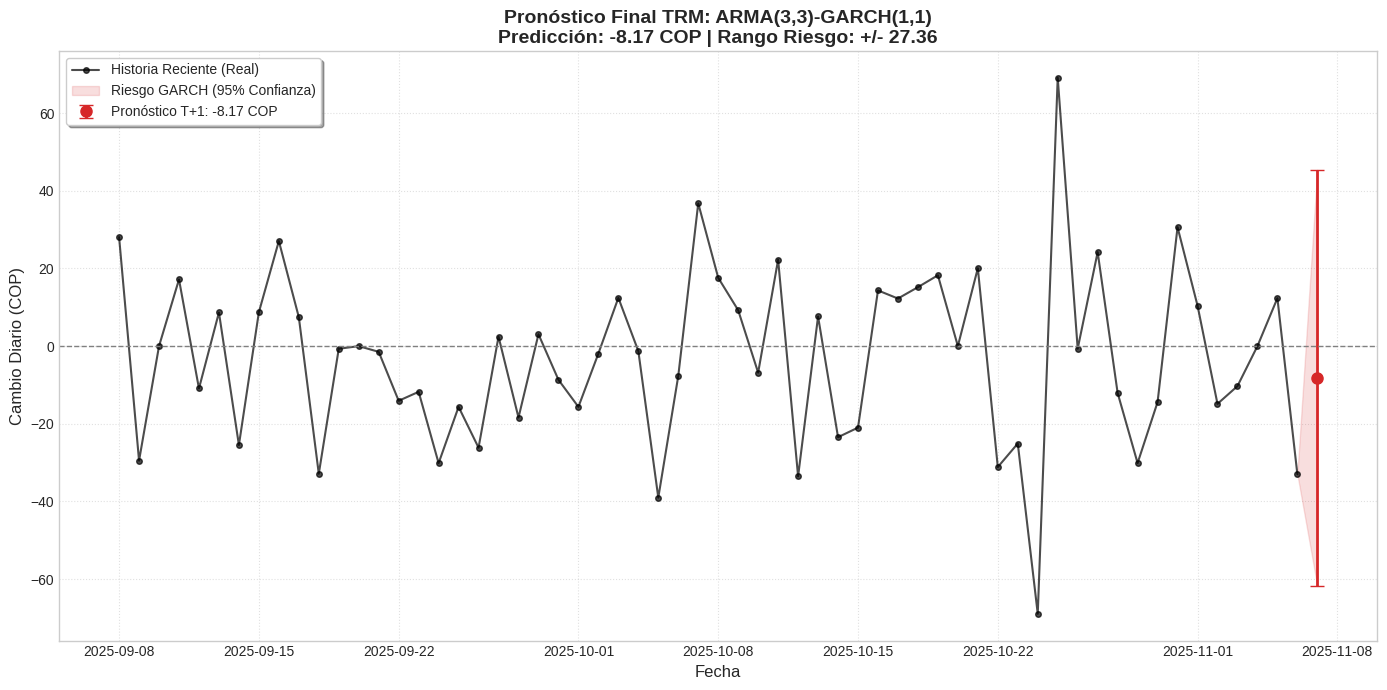

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# 6. PRONÓSTICO Y GRÁFICA FINAL (CORREGIDO)
# ==========================================

# --- 1. Recuperar valores calculados previamente ---
# (Asumimos que estas variables ya existen en tu entorno tras la ejecución anterior)
# Predicción de la media (ARMA)
forecast_norm_arma = results_winner.forecast(steps=1)
val_pred_arma = forecast_norm_arma.iloc[0] if isinstance(forecast_norm_arma, pd.Series) else forecast_norm_arma[0]

# Predicción de la Volatilidad (GARCH)
forecast_var_garch = res_garch_winner.forecast(horizon=1, reindex=False)
val_vol_garch = np.sqrt(forecast_var_garch.variance.iloc[-1, 0])

# Des-normalización
pred_precio_cop = (val_pred_arma * sigma) + mu
riesgo_cop = (val_vol_garch * sigma)

print("\n" + "="*70)
print("     PRONÓSTICO PARA MAÑANA (EN PESOS COLOMBIANOS)")
print("="*70)
print(f"Cambio esperado en la TRM: {pred_precio_cop:.2f} COP")
print(f"Riesgo (Volatilidad estimada): +/- {riesgo_cop:.2f} COP")

# --- 2. Configuración Robusta de Fechas ---
days_plot = 60

# Intentamos obtener la última fecha real, si falla, usamos HOY.
try:
    # Aseguramos que 'periodo' sea datetime y eliminamos errores
    if 'periodo' in df.columns:
        valid_dates = pd.to_datetime(df['periodo'], errors='coerce').dropna()
        if not valid_dates.empty:
            last_date = valid_dates.iloc[-1]
        else:
            last_date = pd.Timestamp.now().normalize()
    else:
        last_date = pd.Timestamp.now().normalize()
except:
    last_date = pd.Timestamp.now().normalize()

# Generamos el rango de fechas para la gráfica
dates_plot = pd.date_range(end=last_date, periods=days_plot)
next_date = last_date + pd.Timedelta(days=1)

# --- 3. Preparación de Datos Históricos ---
recent_Y = Y_t_final.iloc[-days_plot:]
# Reconstruir la historia reciente en Pesos
history_cop = (recent_Y * sigma) + mu

# --- 4. Generación del Gráfico ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7))

# Plot Historia
plt.plot(dates_plot, history_cop.values, color='black', marker='o', markersize=4, alpha=0.7, label='Historia Reciente (Real)')

# Plot Pronóstico (Punto Rojo)
plt.errorbar(next_date, pred_precio_cop,
             yerr=[[riesgo_cop*1.96], [riesgo_cop*1.96]], # Intervalo de confianza 95%
             fmt='o', color='#d62728', ecolor='#d62728', elinewidth=2, capsize=5, markersize=8,
             label=f'Pronóstico T+1: {pred_precio_cop:.2f} COP')

# Cono de Riesgo Visual (Sombreado)
plt.fill_between([dates_plot[-1], next_date],
                 [history_cop.iloc[-1], pred_precio_cop - riesgo_cop*1.96],
                 [history_cop.iloc[-1], pred_precio_cop + riesgo_cop*1.96],
                 color='#d62728', alpha=0.15, label='Riesgo GARCH (95% Confianza)')

# Líneas de referencia y etiquetas
plt.title(f'Pronóstico Final TRM: ARMA(3,3)-GARCH(1,1)\nPredicción: {pred_precio_cop:.2f} COP | Rango Riesgo: +/- {riesgo_cop:.2f}', fontsize=14, fontweight='bold')
plt.ylabel('Cambio Diario (COP)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Leyenda
plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np

# ==========================================
# CÁLCULO DE ERROR CUADRÁTICO MEDIO (MSE) Y RMSE
# ==========================================

print("\n" + "="*70)
print("EVALUACIÓN DE PRECISIÓN DEL MODELO (MSE & RMSE)")
print("="*70)

# --- 1. DATOS REALES VS PREDICHOS (NORMALIZADOS) ---
y_true_norm = Y_t_final
y_pred_norm = results_winner.fittedvalues

# Cálculo MSE Normalizado
mse_norm = mean_squared_error(y_true_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)

print("--- EN ESCALA NORMALIZADA (Desviaciones Estándar) ---")
print(f"MSE (Normalizado):  {mse_norm:.4f}")
print(f"RMSE (Normalizado): {rmse_norm:.4f}")
print("Interpetación: El modelo se equivoca en promedio 0.9 desviaciones estándar.")

# --- 2. DATOS REALES VS PREDICHOS (PESOS COLOMBIANOS) ---
# Des-normalizamos ambos vectores
y_true_cop = (y_true_norm * sigma) + mu
y_pred_cop = (y_pred_norm * sigma) + mu

# Cálculo MSE en Pesos
mse_cop = mean_squared_error(y_true_cop, y_pred_cop)
rmse_cop = np.sqrt(mse_cop)

print("\n--- EN ESCALA REAL (Pesos Colombianos) ---")
print(f"MSE (Pesos^2):      {mse_cop:.4f}")
print(f"RMSE (Pesos):       {rmse_cop:.4f} COP")

# --- 3. COMPARACIÓN CON LA VOLATILIDAD ORIGINAL ---
# ¿El modelo es mejor que usar solo el promedio?
std_original = sigma # Desviación estándar de los datos originales
mejora = 1 - (rmse_cop / std_original)

print("\n" + "="*70)
print("CONCLUSIÓN DE DESEMPEÑO:")
print(f"El error promedio de predicción es de +/- {rmse_cop:.2f} pesos.")
print(f"Volatilidad original de la serie: {std_original:.2f} pesos.")
if rmse_cop < std_original:
    print(f"✅ EL MODELO AGREGA VALOR: Reduce la incertidumbre en un {mejora*100:.2f}%")
else:
    print("⚠️ EL MODELO NO SUPERA AL PROMEDIO (Ruido excesivo).")
print("="*70)


EVALUACIÓN DE PRECISIÓN DEL MODELO (MSE & RMSE)
--- EN ESCALA NORMALIZADA (Desviaciones Estándar) ---
MSE (Normalizado):  2.7689
RMSE (Normalizado): 1.6640
Interpetación: El modelo se equivoca en promedio 0.9 desviaciones estándar.

--- EN ESCALA REAL (Pesos Colombianos) ---
MSE (Pesos^2):      1014.8663
RMSE (Pesos):       31.8570 COP

CONCLUSIÓN DE DESEMPEÑO:
El error promedio de predicción es de +/- 31.86 pesos.
Volatilidad original de la serie: 19.14 pesos.
⚠️ EL MODELO NO SUPERA AL PROMEDIO (Ruido excesivo).


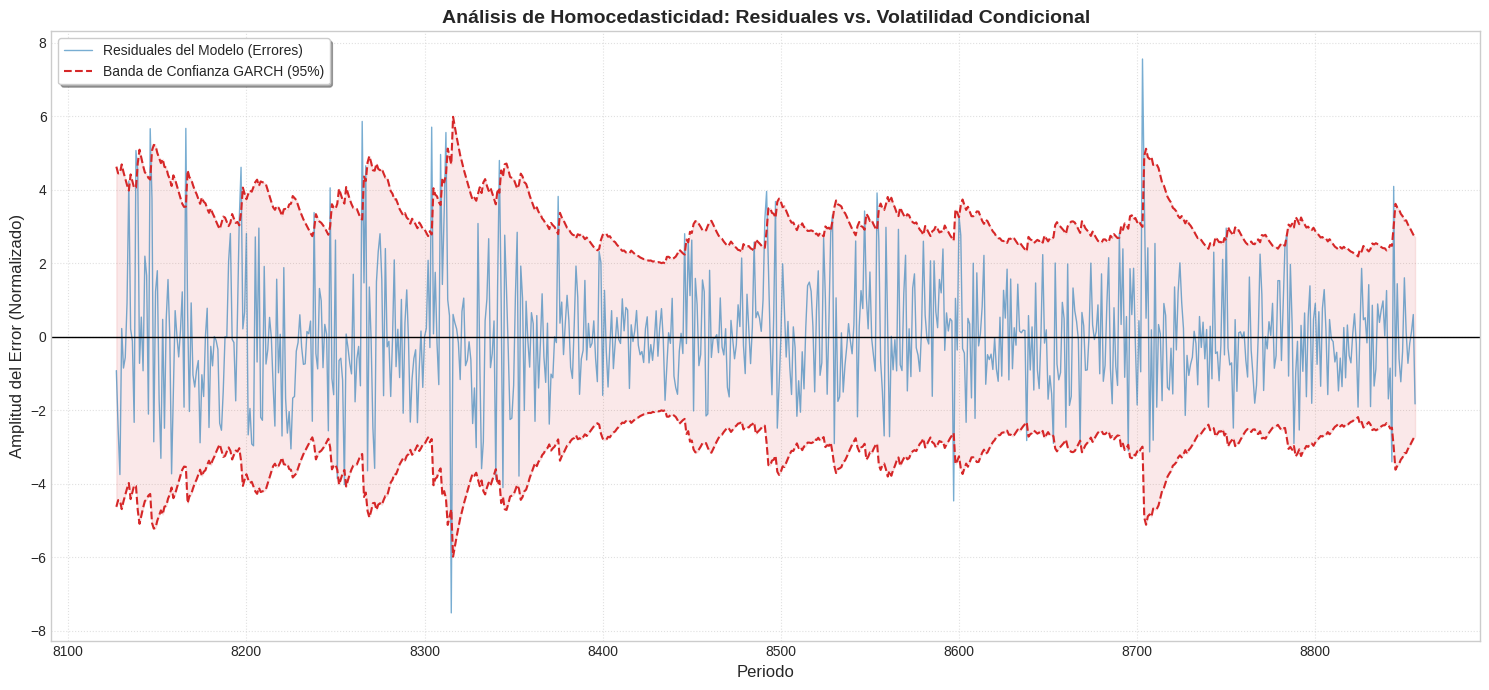

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# VISUALIZACIÓN: RESIDUALES VS INTERVALOS DE CONFIANZA DINÁMICOS
# ==========================================

plt.figure(figsize=(15, 7))

# 1. Graficar los Residuales del ARMA (Lo que no pudimos predecir)
plt.plot(residuals_winner.index, residuals_winner,
         color='#1f77b4', alpha=0.6, linewidth=1, label='Residuales del Modelo (Errores)')

# 2. Graficar las Bandas de Volatilidad GARCH (El riesgo estimado)
# Usamos 1.96 para un intervalo de confianza del 95%
upper_band = 1.96 * conditional_volatility
lower_band = -1.96 * conditional_volatility

plt.plot(conditional_volatility.index, upper_band,
         color='#d62728', linestyle='--', linewidth=1.5, label='Banda de Confianza GARCH (95%)')
plt.plot(conditional_volatility.index, lower_band,
         color='#d62728', linestyle='--', linewidth=1.5)

# 3. Decoración y Estilo
plt.title('Análisis de Homocedasticidad: Residuales vs. Volatilidad Condicional', fontsize=14, fontweight='bold')
plt.ylabel('Amplitud del Error (Normalizado)', fontsize=12)
plt.xlabel('Periodo', fontsize=12)
plt.axhline(0, color='black', linewidth=1)

# Rellenar el área de confianza para mejor visualización
plt.fill_between(conditional_volatility.index, lower_band, upper_band, color='#d62728', alpha=0.1)

plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.show()

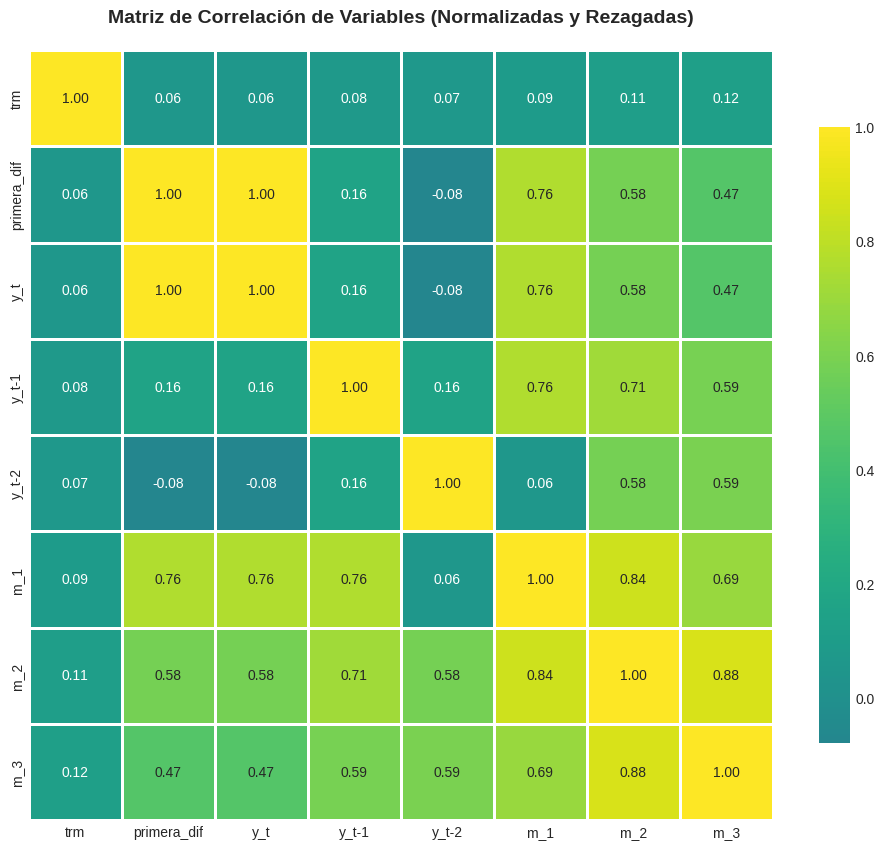


Interpretación Clave:
1. TRM vs Diferencias: La correlación debe ser baja (cercana a 0), lo que confirma la estacionariedad.
2. Predictoras (y_t-k y m_k): La correlación entre estas variables será alta, lo que indica Multicolinealidad.


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definición de las columnas de interés para la matriz (niveles, diferencias y features)
correlation_cols = [
    'trm',
    'primera_dif',
    'y_t',
    'y_t-1',
    'y_t-2',
    'm_1',
    'm_2',
    'm_3'
]

# Seleccionamos las columnas y calculamos la matriz
# Usamos .corr() solo en las columnas que existen y no tienen nulos
corr_matrix = df_preprocessed[correlation_cols].corr()

# Creamos el heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='viridis',
            center=0,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Matriz de Correlación de Variables (Normalizadas y Rezagadas)', fontsize=14, fontweight='bold', pad=20)
plt.show()

print("\nInterpretación Clave:")
print("1. TRM vs Diferencias: La correlación debe ser baja (cercana a 0), lo que confirma la estacionariedad.")
print("2. Predictoras (y_t-k y m_k): La correlación entre estas variables será alta, lo que indica Multicolinealidad.")

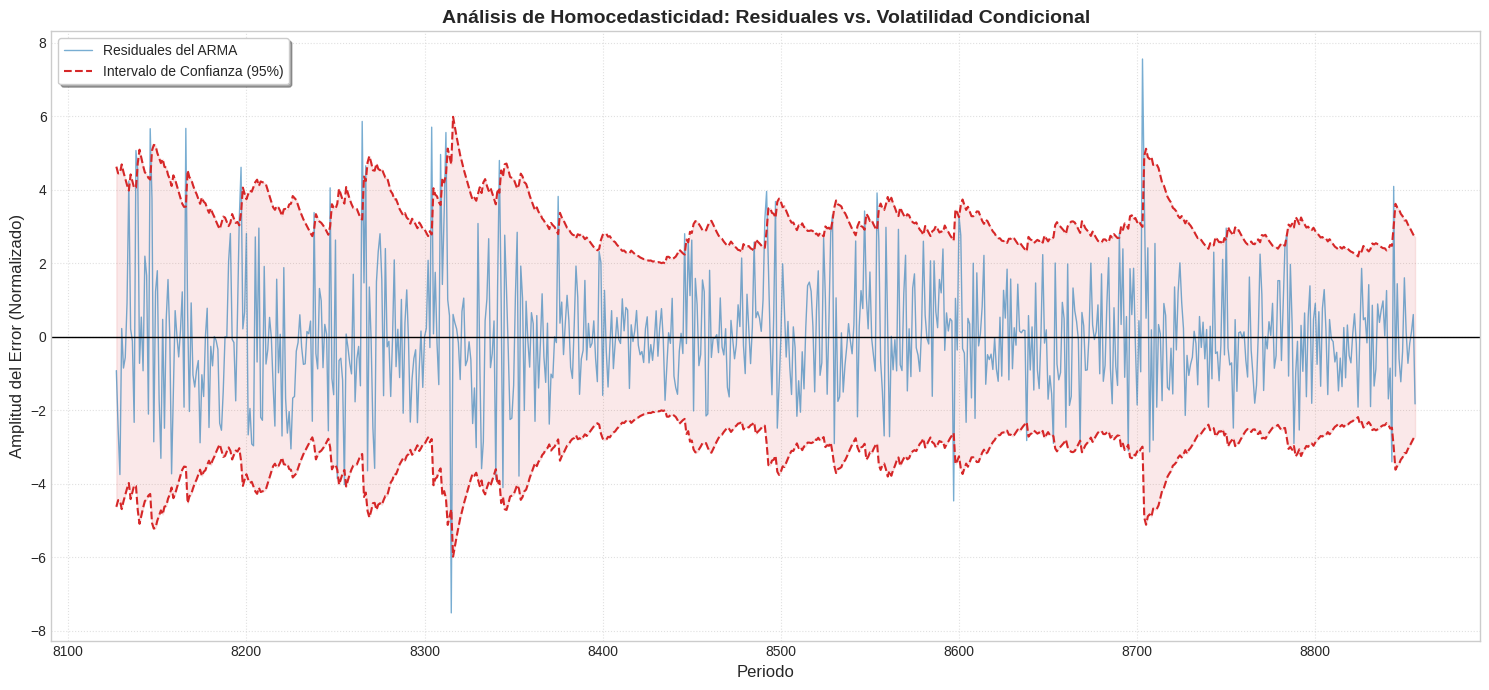

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Necesario si el índice de los residuales es un Timestamp

# ==========================================
# CÓDIGO PARA VISUALIZAR RESIDUALES Y VOLATILIDAD GARCH
# ==========================================

plt.figure(figsize=(15, 7))

# 1. Graficar los Residuales del ARMA (los errores que el modelo no pudo explicar)
plt.plot(residuals_winner.index, residuals_winner,
         color='#1f77b4', alpha=0.6, linewidth=1, label='Residuales del ARMA')

# 2. Definir y Graficar las Bandas Dinámicas de Volatilidad (Intervalo de Confianza 95%)
# La volatilidad es el Std Dev (sigma) predicha por GARCH
# Multiplicamos por 1.96 para obtener el 95% de confianza (2 * sigma)
upper_band = 1.96 * conditional_volatility
lower_band = -1.96 * conditional_volatility

plt.plot(conditional_volatility.index, upper_band,
         color='#d62728', linestyle='--', linewidth=1.5, label='Intervalo de Confianza (95%)')
plt.plot(conditional_volatility.index, lower_band,
         color='#d62728', linestyle='--', linewidth=1.5)

# 3. Decoración y Estilo
plt.title('Análisis de Homocedasticidad: Residuales vs. Volatilidad Condicional', fontsize=14, fontweight='bold')
plt.ylabel('Amplitud del Error (Normalizado)', fontsize=12)
plt.xlabel('Periodo', fontsize=12)
plt.axhline(0, color='black', linewidth=1) # Línea de referencia en cero
plt.fill_between(conditional_volatility.index, lower_band, upper_band, color='#d62728', alpha=0.1)

plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Este gráfico demuestra visualmente que el GARCH corrige la Propiedad 3.

In [60]:
import pandas as pd
import numpy as np
import warnings

# Ignorar warnings para una salida más limpia
warnings.filterwarnings("ignore")

# --- 1. Definición del Contexto y Carga ---
# Intentaremos cargar el archivo con las rutas conocidas y codificación latin-1
file_name_1 = 'Tasa de cambio del peso colombiano .xlsx - Tasa de cambio del peso colombi.csv'
file_name_2 = '/content/Tasa de cambio del peso colombiano (Tasa de cambio del peso colombi).csv'
N_DATA = 730

try:
    df = pd.read_csv(file_name_1, sep=',', encoding='latin-1')
except FileNotFoundError:
    # Usar ruta alternativa si la primera falla
    df = pd.read_csv(file_name_2, sep=',', encoding='latin-1')
except Exception as e:
    # Manejar otros errores de carga
    print(f"Error al cargar el archivo: {e}")
    raise

# 2. Selección de la columna 'trm' y filtrado de los últimos 730 días.
trm_series = df['trm'].dropna()

if len(trm_series) >= N_DATA:
    trm_last_730 = trm_series.iloc[-N_DATA:]
else:
    # Caso de advertencia si la data es insuficiente
    trm_last_730 = trm_series.copy()

# 3. Cálculo de Estadísticos Descriptivos
descriptive_stats = trm_last_730.describe()

# 4. Presentar Resultados
print("\n" + "=" * 60)
print(f"💰 ESTADÍSTICOS DESCRIPTIVOS DE LA TRM (ÚLTIMOS {len(trm_last_730)} DÍAS)")
print("=" * 60)
print(descriptive_stats.to_markdown(numalign="left", stralign="left"))


💰 ESTADÍSTICOS DESCRIPTIVOS DE LA TRM (ÚLTIMOS 730 DÍAS)
|       | trm     |
|:------|:--------|
| count | 730     |
| mean  | 4158.01 |
| std   | 248.679 |
| min   | 3763.43 |
| 25%   | 3958.53 |
| 50%   | 4111.45 |
| 75%   | 4281.99 |
| max   | 4966.33 |
